<a href="https://colab.research.google.com/github/Slautin/2024_Co-navigation/blob/main/2_Co_navigation_experiment_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

April, 2024

Analysis codes for the article: **Bayesian co-navigation: Dynamic Designing of the Material Digital Twins via Active Learning**

Part 2/2. Experiment-theory exploration.

* Author [Boris Slautin](https://scholar.google.com/citations?hl=ru&view_op=list_works&gmla=AH70aAU_JtxEIQgg_RTLPnUSZHKp1J1iDrJUxTZ7Dzw5p5jEtCEug5zMWLCh4A-pe5ekW_9a_aXHOSIjEp-2UT_kypL9DfD7GcD76qEpeOzSkAibBjmm_7RL&user=Y2AXABsAAAAJ)

* BEPS PFM  measurements are performed by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en)

* PTO thin film mas made by [Hiroshi Funakubo](https://scholar.google.co.jp/citations?user=12EJj9gAAAAJ&hl=en)

* [FerroSim](https://github.com/ramav87/FerroSim) lattice model codes from [Rama K. Vasudevan](https://scholar.google.com/citations?user=b2XP9A4AAAAJ&hl=en)

* [GPax](https://gpax.readthedocs.io/en/latest/) lib is developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)

* Idea and project leadership by [Sergei Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

This notebook is almost the same as the previous one but shorter and with some differences in co-navigation functions

In [1]:
!pip install sidpy
!pip install bglib
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git;
!pip install -q gpax
!pip install -e git+https://github.com/ramav87/FerroSim.git@rama-dev#egg=FerroSim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.8/210.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 8.0 MB/s eta 0:00:00
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.7-py3-none-any.whl size=21297 sha256=d553221013937100dc3e54888975816671289c7cb8f289ecab8ddf46df877014
  Stored in directory: /root/.cache/pip/wheels/ff/b2/88/174ead714f23773cc7563912e763404c814d705bf8eb7715d4
Successfully built numpy-groupies
  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-am5hfkaq
  Ru

**Session must be restarted after ferrosim lib uploading.**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

import pyUSID as usid
import h5py
import math

from atomai import utils
import torch
import gpax
import jax.numpy as jnp
import numpyro.distributions as dist
import numpyro

from typing import Dict
from itertools import product

from ferrosim import Ferro2DSim

/content/src/ferrosim/ferrosim/simclass.py:590: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)


Upload experimental data

In [2]:
!gdown https://drive.google.com/file/d/1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP
From (redirected): https://drive.google.com/uc?id=1t1_-ZUOM349HEbjvyAwaZfXBN7FRJwMP&confirm=t&uuid=bb5c56ce-3a65-48f4-bc0c-b2733bb9a814
To: /content/BEPS_1d7um_0009.h5
100% 3.04G/3.04G [00:18<00:00, 165MB/s]


In [3]:
#@title auxiliary functions
def correct_phase(phase, visualize=False):
  min_ = np.min(phase)
  max_ = np.max(phase)

  pha_correct = np.where(phase > 1.57, phase + (min_-max_), phase)
  pha_correct = pha_correct +np.pi - 0.75

  if visualize:
    plt.figure(figsize=(4,3))
    plt.hist(phase.ravel(), bins = 500, color='blue', label='before')
    plt.hist(pha_correct.reshape(-1),bins = 500, color='green', label='after');
    plt.axvline(np.pi, color ='red')
    plt.axvline(0, color ='red')
    plt.legend()

  return pha_correct

def shoelace_formula(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def get_area(loop_x, loop_y):
  x0, x1 = loop_x[: len(loop_x)//2], loop_x[len(loop_x)//2:]
  y0, y1 = loop_y[: len(loop_y)//2], loop_y[len(loop_y)//2:]
  p1 = np.abs(shoelace_formula(x0, y0))
  p2 = np.abs(shoelace_formula(x1, y1))
  return p1 + p2

def normalize(data):
  if np.ptp(data) == 0:
    return [np.min(data),np.ptp(data)], np.ones(data.shape)*0.5
  else:
    return [np.min(data),np.ptp(data)], (data - np.min(data))/(np.ptp(data))

In [4]:
#@title functions for saving data

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)
    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

# 1. Import experimental data

In [5]:
with h5py.File(r'/content/BEPS_1d7um_0009.h5', 'r+') as h5_BEPS1:

  sho_mat1 = h5_BEPS1['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']
  spec_val1 = h5_BEPS1['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values']
  pos_inds1 = h5_BEPS1['Measurement_000/Channel_000/Position_Indices']
  pos_dim_sizes1 = [np.max(pos_inds1[:,0])+1, np.max(pos_inds1[:,1]+1)]

  sho_mat_ndim1 = sho_mat1[:].reshape(pos_dim_sizes1[0], pos_dim_sizes1[1], -1)
  amp_mat_ndim1 = sho_mat_ndim1['Amplitude [V]']
  phase_mat_ndim1 = sho_mat_ndim1['Phase [rad]']
  spec_val1 = np.array(spec_val1)

  pha_correct = correct_phase(phase_mat_ndim1, visualize=False)

In [6]:
#split to cycles
cycles = 8

pr_mat_ndim1 = (amp_mat_ndim1*np.cos(pha_correct))*1E3
p_offfield1 = pr_mat_ndim1[:,:,1::2]
p_offfield1 = p_offfield1.reshape(*p_offfield1.shape[:-1],cycles,
                                p_offfield1.shape[-1]//cycles)

v_step1 = spec_val1[0, ::2]
v_step1 = v_step1.reshape(cycles, len(v_step1)//cycles)[0]

In [7]:
#averaging loops and crop initial scan for faster exploration
p_offfield1_av = p_offfield1[:,:,1:].mean(2)[:60,:60]

#ground truth areas
thresh = 0.05
areas = np.zeros((p_offfield1_av.shape[:-1]))

for i in range(p_offfield1_av.shape[0]):
  for j in range(p_offfield1_av.shape[1]):
    areas[i,j]  = get_area(v_step1,p_offfield1_av[i,j])

areas = areas

#structural image
st_im = p_offfield1[:,:,0,0][:60,:60]

# 2. Parameter space (E-loop)

In [8]:
#scalarizer
_, norm_area = normalize(areas)

#patch window size
ws = 12

#theshold to binarize
thresh = 0.45

#normalize
_, patch_image = normalize(st_im)

#bin_image
b_im = patch_image < thresh
b_im = b_im.astype(int)

#extract patches for each point on a grid
coordinates = utils.get_coord_grid(patch_image, 1)
pix = int(len(patch_image)+1-ws)

features_all, coords, _ = utils.extract_subimages(patch_image, coordinates, ws)
b_features_all, _, _ = utils.extract_subimages(b_im, coordinates, ws)

features_all = features_all[:,:,:,0]
b_features_all = b_features_all[:,:,:,0]

join_features = np.concatenate([features_all, b_features_all],axis=2)
f_scalarizer = norm_area[coords[:,0].astype(int), coords[:,1].astype(int)]

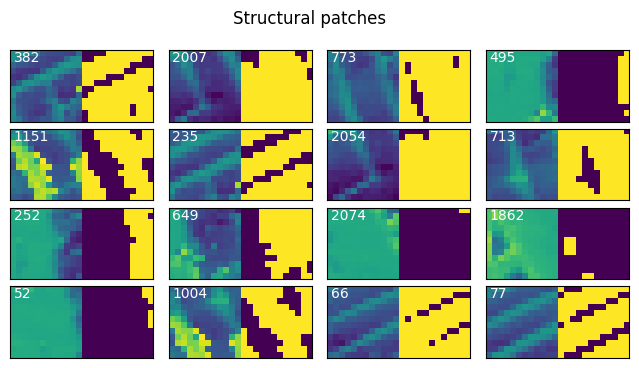

In [12]:
#plot examples of patches
fig, axes = plt.subplots(4, 4, figsize=(8, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(join_features))
    ax.imshow(join_features[i], interpolation='nearest')
    ax.text(0.1, 1.5, str(i), color='white')

# 3. Parameter space (T-loop)

The theoretical parameter space is derived from a large square, symbolizing the a-domain, and from periodically arranged narrow strip domains that depict the 'corrugation' domain structure.

Parameters:

**k** - the edge of the a-domain

**sf** - the distance between narrow 'corrugation' stripes

**ph** - the phase of 'corrugation' periodic structure

In [9]:
#@title theory parameter space functions
def a_domain(k, size=(12,12)):
  a_pattern = np.array([[1 if (i-k < j) else 0 for j in range(size[0])] for i in range(size[1])])
  return a_pattern.astype(bool)

def striped_pattern(stripe_frequency, phase, size=(12,12), stripe_width=2):
  pattern = np.zeros(size, dtype=int)

  for i in range(size[0]):
      for j in range(size[1]):
          if ((i + j) // stripe_width + phase) % stripe_frequency == 0:
              pattern[i, j] = 1

  return pattern.astype(bool)

def res_pattern(k, stripe_frequency, phase, size=(12,12)):
  res = a_domain(k, size=size) + striped_pattern(stripe_frequency, phase, size=size)
  return ~res

In [10]:
#coordinate system in theory latent space
coupling = np.arange(-12,13)
sf = np.arange(1,13)
ph = np.arange(0,12)

coords_th = np.array(list(product(coupling, sf, ph)))

# 4. Ferrosim

In [11]:
#@title FerroSim functions
def ferrosim_calc(patch,
                  gamma = 100,
                  defect_field = (30,0),
                  c_const = 5,
                  Eamp = (1E-9, 2),
                  time_vec_length = 2000,
                  dep_alpha = 1E-9):
  #tiem vec
  time_vec = np.linspace(0,2,time_vec_length)
  flat_patch = np.array(patch.flatten()).astype(bool)

  #defect field
  Efx, Efy = defect_field

  #coupling constant
  k = np.zeros(len(flat_patch))
  k[flat_patch==True] = c_const

  #make defect list
  defect_list = np.ones((len(flat_patch),2))*1E-6
  defect_list[flat_patch==False] = (Efx, Efy)

  #applied field
  Evec_x = Eamp[0]*np.ones(len(time_vec))
  Evec_y = Eamp[1]*np.sin(2*np.pi*time_vec)
  applied_field = np.vstack((Evec_x, Evec_y)).T

  #initial P
  init_p  = np.random.uniform(low = -0.2, high = 0.2, size = (ws,ws,2))*1.0E-9

  sim = Ferro2DSim(n=ws,
                  time_vec = time_vec,
                  appliedE=applied_field,
                  defects=defect_list,
                  k=k,
                  dep_alpha = dep_alpha,
                  mode = 'tetragonal',
                  gamma=gamma,
                  initial_p = init_p)

  sim.runSim();

  return (applied_field.T, sim.results['Polarization'])

def plot_DKL_pred(mean, var, coords, seeds):
  fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=100)

  ax[0].scatter(coords[:,1],coords[:,0], c=mean, cmap='coolwarm', s=1)
  ax[0].set_aspect(1)
  ax[0].set_title('Prediction')
  ax[1].scatter(coords[:,1],coords[:,0], c=var, cmap='coolwarm', s=1)
  ax[1].set_aspect(1)
  ax[1].set_title('Uncertainty')

  for _ in ax:
    _.set_xlabel('$z_1$')
    _.set_ylabel('$z_2$')
    _.scatter(coords[seeds,1], coords[seeds,0], marker='x', color='black',
              s=10)

  return fig

from mpl_toolkits.mplot3d import Axes3D

def plot_DKL_pred3D(mean, var, coords, seeds):
    fig, ax = plt.subplots(1,2, figsize=(6,3), subplot_kw={'projection': '3d'})

    ax[0].scatter(coords[:,0],coords[:,1], coords[:,2], c=mean, cmap='coolwarm',
                  s=1, alpha=0.3)
    ax[0].set_aspect('auto')
    ax[0].set_title('Prediction')
    ax[1].scatter(coords[:,0],coords[:,1], coords[:,2], c=var, cmap='coolwarm',
                  s=1, alpha=0.3)
    ax[1].set_aspect('auto')
    ax[1].set_title('Uncertainty')

    for _ in ax:
      _.scatter(coords[seeds,0], coords[seeds,1], coords[seeds,2], marker='x',
                color='black',
                s=5)
    return fig

from typing import Union

# 5. Exploration

In [12]:
#theory
X          = torch.tensor(np.array([res_pattern(*x) for x in coords_th]))

#experiment
X_exp      = features_all.reshape(len(features_all), features_all.shape[1]* features_all.shape[2])
loop_exp   = p_offfield1_av
volt_exp   = v_step1
y_exp      = f_scalarizer
coords_exp = coords

#theory adjustment space
a_dep = np.linspace(0.001, 1, 50)
coupl_coef = np.linspace(0.001, 1, 50)
coord_adj = np.array(list(product(coupl_coef, a_dep)))

##Processing

In [13]:
#@title auxilary and visualization func
def sigmoid_decay(start, end, num_steps, a=1, b=0):
    """
    Generate a smooth decay sequence from start to end over num_steps using sigmoid function.

    Args:
    - start (float): Starting value.
    - end (float): Ending value.
    - num_steps (int): Number of steps in the decay sequence.
    - a (float): Slope parameter for sigmoid function.
    - b (float): Shift parameter for sigmoid function.

    Returns:
    - np.ndarray: Smooth decay sequence.
    """
    # Generate the decay sequence using sigmoid function
    x = np.linspace(-5, 5, num_steps)  # Adjust the range for the smoothness of the curve
    decay_sequence = 1 / (1 + np.exp(-a * (x - b)))

    # Scale and shift the decay sequence to fit the range [start, end]
    decay_sequence = start + (end - start) * decay_sequence

    return decay_sequence

def vis_seeds(seeds, X, loops_arrays, par):
  figsize = (3, len(seeds)//3+1)

  fig, ax = plt.subplots(figsize[1], figsize[0], figsize = (figsize[0]*2.2, figsize[1]*2))

  ax_list = ax.flatten()
  loops_arrays = np.array(loops_arrays)[:,:,1]

  for i in range(len(seeds)):
    loop = loops_arrays[i,:,loops_arrays.shape[-1]//2:]
    area = round(get_area(*loop),2)

    ax_list[i].plot(*loop)
    ax_list[i].set_title('Area {}'.format(area), fontsize=8)
    axins = inset_axes(ax_list[i],
                    width="35%",  # width of inset axes
                    height="35%",  # height of inset axes
                    loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X[seeds[i]], cmap='coolwarm',
                      interpolation='nearest', vmin=0, vmax=1)

  for _ in ax_list:
    _.set_xlim(-2.1, 2.1)
    _.set_xticks([])
    _.set_yticks([])

  fig.suptitle(f'Coupling coef. {round(par[0],2)}; Depolarization coef.  {round(par[1],2)}')
  plt.show()

def vis_seeds_exp(seeds, X, loops_arrays_y, loops_array_x, coords_exp):
  figsize = (3, len(seeds)//3+1)

  fig, ax = plt.subplots(figsize[1], figsize[0], figsize = (figsize[0]*2.2, figsize[1]*2))

  ax_list = ax.flatten()

  for i in range(len(seeds)):
    cd = coords_exp[seeds[i]].astype(int)
    loop = loop_exp[cd[0], cd[1]]
    area = round(get_area(loops_array_x, loop),2)

    ax_list[i].plot(loops_array_x, loop)
    ax_list[i].set_title('Area {}'.format(area), fontsize=8)
    axins = inset_axes(ax_list[i],
                    width="35%",  # width of inset axes
                    height="35%",  # height of inset axes
                    loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])

    x_im = X[seeds[i]]

    im = axins.imshow(x_im, cmap='coolwarm', interpolation='nearest', vmax=1, vmin=0)

  for _ in ax_list:
    _.set_ylim(-20, 20)
    _.set_xlim(-13, 13)
    _.set_xticks([])
    _.set_yticks([])

  plt.show()

def gt_grid(pattern):
  loops = []
  par = []
  ac = []
  a_list = np.linspace(0,1,3)
  coup_list = np.linspace(0.1,2,4)

  for a in a_list:
    for coup in coup_list:
      ac.append((a, coup))
      l = lambda_y(b_features_all[ind], coup, a)
      loops.append(l)
      par.append((a, coup))

  loop_ar = np.array(loops)[:,:,1]

  fig, ax = plt.subplots(3,4, figsize=(12,8))

  fig.text(0.04, 0.5, 'Depolarization constant', va='center', rotation='vertical')
  fig.text(0.5, 0.04, 'Coupling', va='center')

  for i,_ in enumerate(ax.flatten()):
    _.plot(*loop_ar[i])
    _.set_xticks([])
    _.set_yticks([])
    _.set_ylim(-40,40)
    _.set_xlim(-2,2)
    _.set_title('c = {}, a = {}'.format(round(ac[i][1],2),
                                        round(ac[i][0], 2)))

def plot_model_adj(X_tr, X_test, f_pred, f_var, acq):
  next_seed = int(np.argmax(acq))

  fig, ax = plt.subplots(1,3, figsize=(11,3))
  ax[0].scatter(X_test[:,0], X_test[:,1], c=f_pred, cmap='coolwarm')
  ax[0].set_title('Predicted MSE')
  ax[1].scatter(X_test[:,0], X_test[:,1], c=f_var, cmap='coolwarm')
  ax[1].set_title('Uncertainty MSE')
  ax[2].scatter(X_test[:,0], X_test[:,1], c=acq, cmap='coolwarm')
  ax[2].set_title('UCB')

  for _ in ax:
    _.set_aspect(1)
    _.set_xlabel(r'$K$')
    _.set_ylabel(r'$\alpha_{dep}$')
    _.scatter(X_tr[:,0], X_tr[:,1], c='black', marker='x')

  ax[2].scatter(X_test[next_seed,0], X_test[next_seed,1],
                c='lightgreen', marker='o', s=50)

  plt.show()
  return fig

In [17]:
#@title Co-navigation functions
def seeds_theory(X, n=5, adj_p = (0.1, 0.1)):
  seeds = np.random.choice(np.arange(len(X)), N, replace=False)

  X_train = X[seeds]
  model_res = [lambda_y(xx, adj_p[0]*10, adj_p[1]) for xx in X_train]

  X_train_dkl = X_train.reshape(len(X_train), -1)
  y_train     = np.array([get_area(xx[0][1, len(xx[0])//2:], xx[1][1, len(xx[0])//2:]) for xx in model_res])
  _, y_train_dkl = normalize(y_train)
  return seeds, X_train_dkl, y_train_dkl, y_train, model_res

def seeds_exp(X, loops_arrays, volt_exp, coords_exp, n=5):
  seeds_exp = np.random.choice(np.arange(len(X)), n, replace=False)
  y_train_exp = []
  for i in range(len(seeds_exp)):
    cd = coords_exp[seeds_exp[i]].astype(int)
    loop = loop_exp[cd[0], cd[1]]
    area = get_area(volt_exp, loop)
    y_train_exp.append(area)

  X_train_exp = torch.tensor(X[seeds_exp])
  return seeds_exp, X_train_exp, y_train_exp

def iteration_theory(seeds, X, X_train_dkl, y_train, coords, adj_p, mem_tail, visualise=False):

  X_train_dkl = X_train_dkl.reshape(len(X_train_dkl), -1)
  if len(X_train_dkl) > mem_tail:
    X_train_dkl_short = X_train_dkl[-mem_tail:]
    y_train_short = y_train[-mem_tail:]
  else:
    X_train_dkl_short = X_train_dkl
    y_train_short = y_train

  data_dim = X_train_dkl_short.shape[-1]
  _, y_train_dkl_short = normalize(y_train_short)

  key1, key2 = gpax.utils.get_keys()
  dklgp = gpax.viDKL(data_dim, z_dim=3, kernel='RBF')

  dklgp.fit(key1, X_train_dkl_short, y_train_dkl_short)

  mean, var = dklgp.predict(key2, X.reshape(len(X), -1))

  acq = gpax.acquisition.UE(key2, dklgp, X.reshape(len(X), -1),
                            recent_points=X_train_dkl_short, penalty='delta')

  next_point_idx = var.argmax()

  #plot results
  if visualise:
    fig = plot_DKL_pred3D(mean, var, coords, seeds)
    axx = fig.get_axes()[1]
    axx.scatter(coords[next_point_idx,0],
                coords[next_point_idx,1],
                coords[next_point_idx,2],
                color='lightgreen', edgecolors='black', s=15)
    plt.show()


  seeds = np.append(seeds, next_point_idx)
  X_next = X[next_point_idx]
  X_train_dkl = X[seeds]

  m_next = lambda_y(X_next, adj_p[0]*10, adj_p[1])

  y_train_next = get_area(m_next[0][1, len(m_next[0])//2:], m_next[1][1, len(m_next[0])//2:])
  y_train = np.append(y_train, y_train_next)

  #plot loop
  if visualise:
    fig,ax = plt.subplots(figsize=(3,2.5))
    plt.plot(m_next[0][1, len(m_next[0])//2:], m_next[1][1, len(m_next[0])//2:], c='black')
    axins = inset_axes(ax,
                      width="35%",  # width of inset axes
                      height="35%",  # height of inset axes
                      loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X[next_point_idx], cmap='coolwarm',
                      interpolation='nearest',
                      vmin=0, vmax=1)

    plt.title(f'Coupling {round(adj_p[0]*10,2)}, Depolarization const {round(adj_p[1],2)}, area {round(y_train_next,2)}')
    plt.show()

  return seeds, X_train_dkl, y_train, np.array([mean, var]), dklgp

def iteration_exp(seeds, X_exp, y_exp, volt_exp, coords, visualise=False):
  X_train_exp = X_exp[seeds]
  y_train = y_exp.reshape(-1, y_exp.shape[-1])[seeds]
  y_train_exp = np.array(list([get_area(volt_exp, x) for x in y_train]))
  data_dim = X_train_exp.shape[-1]

  key1, key2 = gpax.utils.get_keys()
  dklgp = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
  _, y_train_exp_dkl = normalize(y_train_exp)
  dklgp.fit(key1, X_train_exp, y_train_exp_dkl)
  mean, var = dklgp.predict(key2, X_exp, batch_size=128)

  acq = gpax.acquisition.UE(key2, dklgp, X_exp,
                            recent_points=X_train_exp, penalty='delta', penalty_factor=0.01)

  next_point_idx = acq.argmax()
  print(next_point_idx)

  if visualise:
    fig = plot_DKL_pred(mean, var, coords, seeds=seeds)
    axx = fig.get_axes()
    for _ in axx:
      _.set_xlabel('')
      _.set_ylabel('')

    axx[1].scatter(coords[next_point_idx,1],
                coords[next_point_idx,0],
                color='lightgreen', edgecolors='black', s=15)
    plt.show()

  seeds = np.append(seeds, next_point_idx)
  X_next = X_exp[next_point_idx]

  cd = coords[next_point_idx].astype(int)
  y_next = get_area(volt_exp, y_exp[cd[0],cd[1]])


  #plot loop
  if visualise:
    fig,ax = plt.subplots(figsize=(3,2.5))
    plt.plot(volt_exp, y_exp[cd[0],cd[1]], c='black')
    axins = inset_axes(ax,
                      width="35%",  # width of inset axes
                      height="35%",  # height of inset axes
                      loc='upper left')
    axins.set_xticks([])
    axins.set_yticks([])
    im = axins.imshow(X_next.reshape(int(data_dim**0.5), int(data_dim**0.5)),
                      cmap='coolwarm',
                      interpolation='nearest',
                      vmin=0, vmax=1,
                      origin='lower')

    plt.title(f'Area {round(y_next,2)}')
    plt.show()

  X_train_exp = X_exp[seeds]
  y_train_exp = np.append(y_train_exp, y_next)

  return seeds, X_train_exp, y_train_exp, np.array([mean, var]), dklgp


def model_adjust_iteration(seed_model, mse_error, X_test, mem_tail, beta=0.1,
                           lengthscale_prior_dist=None, structural=False):
  if len(mse_error) > mem_tail:
    y_model = mse_error[-mem_tail:]
    X_tr = X_test[seed_model][-mem_tail:]
  else:
    y_model = mse_error
    X_tr = X_test[seed_model]

  if len(X_tr)>50:
    recent_points = X_tr[-50:]
  else:
    recent_points = X_tr

  def mean_function(x):
    return np.max(y_model)
  print(np.max(y_model))

  def parabolic(x: jnp.ndarray,  params: Dict[str, float]) -> jnp.ndarray:
    return jnp.array([params['alpha']*(x[:,0] - params["x0"])**2
            + params['beta']*(x[:,1] - params["y0"])**2])

  def parabolic_priors():
    # Sample model parameters
    alpha = numpyro.sample("alpha", dist.HalfNormal(10))
    beta  = numpyro.sample("beta", dist.HalfNormal(10))
    x0    = numpyro.sample("x0", dist.Uniform(0.1,2))
    y0    = numpyro.sample("y0", dist.Uniform(0.1,1))
    # Return sampled parameters as a dictionary
    return {"alpha": alpha, "beta": beta, "x0": x0, "y0": y0}


  key1, key2 = gpax.utils.get_keys(1)

  if structural:
    gp_model = gpax.viGP(input_dim=2,
                        kernel='RBF',
                        guide='delta',
                        lengthscale_prior_dist=lengthscale_prior_dist,
                        mean_fn=parabolic,
                        mean_fn_prior = parabolic_priors,
                        noise_prior_dist = None,)
  else:
    gp_model = gpax.viGP(input_dim=2,
                        kernel='RBF',
                        guide='delta',
                        lengthscale_prior_dist=lengthscale_prior_dist,
                        mean_fn= mean_function,
                        noise_prior_dist = None,)

  gp_model.fit(key1, X_tr, y_model, num_steps=250, step_size=0.05)

  ei = gpax.acquisition.UCB(key2, gp_model, X_test, maximize=False, beta=beta)
  print(max(ei), min(ei))
  f_pred, f_var = gp_model.predict(key2, X_test)

  next_seed = int(np.argmax(ei))

  plot_model_adj(X_tr, X_test, f_pred, f_var, ei)

  # fig, ax = plt.subplots(1,3, figsize=(11,3))
  # ax[0].scatter(X_test[:,0], X_test[:,1], c=f_pred, cmap='coolwarm')
  # ax[0].set_title('Predicted MSE')

  # ax[1].scatter(X_test[:,0], X_test[:,1], c=f_var, cmap='coolwarm')
  # ax[1].set_title('Uncertainty MSE')

  # ax[2].scatter(X_test[:,0], X_test[:,1], c=ei, cmap='coolwarm')
  # ax[2].set_title('UCB')

  # for _ in ax:
  #   _.set_aspect(1)
  #   _.set_xlabel('Coupling constant /10')
  #   _.set_ylabel('Depolarization constant')
  #   _.scatter(X_tr[:,0], X_tr[:,1], c='black', marker='x')
  # ax[2].scatter(X_test[next_seed,0], X_test[next_seed,1],
  #               c='lightgreen', marker='o', s=50)
  # plt.show()


  return next_seed, np.array([f_pred, f_var]), gp_model.get_samples()


----------------- Seed points theory -----------------

---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.12it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.60it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.72it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.76it/s]


---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.84it/s]



----------------- Seed points exp. -----------------


----------------- Iteration exp. 0 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 507.89it/s, init loss: 13174.8340, avg. loss [951-1000]: 12476.1286]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2564
noise            0.1228
0

----------------- Iteration theory 0 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 535.18it/s, init loss: 13233.5127, avg. loss [951-1000]: 12535.1835]



Inferred GP kernel parameters
k_length         [0.36789998 0.32389998 0.36789998]
k_scale          0.38959998
noise            0.0999
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.70it/s]



----------------- Iteration exp. 1 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 366.11it/s, init loss: 13175.7588, avg. loss [951-1000]: 12476.2248]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.25169998
noise            0.1156
1

----------------- Iteration theory 1 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.98it/s, init loss: 13233.3320, avg. loss [951-1000]: 12535.1847]



Inferred GP kernel parameters
k_length         [0.36789998 0.3678     0.3181    ]
k_scale          0.37759998
noise            0.096099995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.47it/s]



----------------- Iteration exp. 2 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 366.73it/s, init loss: 13176.6348, avg. loss [951-1000]: 12476.2458]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2482
noise            0.108399995
2

----------------- Iteration theory 2 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.17it/s, init loss: 13233.3594, avg. loss [951-1000]: 12535.2362]



Inferred GP kernel parameters
k_length         [0.36789998 0.3126     0.36789998]
k_scale          0.38799998
noise            0.0938
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.87it/s]



----------------- Iteration exp. 3 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 360.16it/s, init loss: 13177.5000, avg. loss [951-1000]: 12476.2241]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2452
noise            0.1019
3

----------------- Iteration theory 3 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.83it/s, init loss: 13233.5498, avg. loss [951-1000]: 12535.2296]



Inferred GP kernel parameters
k_length         [0.36789998 0.3189     0.36789998]
k_scale          0.3981
noise            0.0984
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.30it/s]



----------------- Iteration exp. 4 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 359.95it/s, init loss: 13178.4922, avg. loss [951-1000]: 12476.1329]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.243
noise            0.095699996
4

----------------- Iteration theory 4 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 542.93it/s, init loss: 13233.3652, avg. loss [951-1000]: 12535.2414]



Inferred GP kernel parameters
k_length         [0.36789998 0.3268     0.36789998]
k_scale          0.3908
noise            0.100099996
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.99it/s]



----------------- Iteration exp. 5 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 360.96it/s, init loss: 13179.4619, avg. loss [951-1000]: 12475.9489]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.24149999
noise            0.0893
5

----------------- Iteration theory 5 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 535.03it/s, init loss: 13233.0947, avg. loss [951-1000]: 12535.0713]



Inferred GP kernel parameters
k_length         [0.36789998 0.32799998 0.36789998]
k_scale          0.37
noise            0.10569999
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.28it/s]



----------------- Theory model tune iter_5 -----------------

MSE 2.05

----------------- Iteration exp. 6 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 370.19it/s, init loss: 13180.4229, avg. loss [951-1000]: 12475.7493]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2401
noise            0.0841
6

----------------- Iteration theory 6 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 539.34it/s, init loss: 13233.1875, avg. loss [951-1000]: 12535.2933]



Inferred GP kernel parameters
k_length         [0.36789998 0.3261     0.36789998]
k_scale          0.41689998
noise            0.0954
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.88it/s]



----------------- Iteration exp. 7 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 300.20it/s, init loss: 13181.3213, avg. loss [951-1000]: 12475.5371]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23869999
noise            0.0796
7

----------------- Iteration theory 7 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 443.98it/s, init loss: 13232.8379, avg. loss [951-1000]: 12535.1267]



Inferred GP kernel parameters
k_length         [0.36789998 0.325      0.36789998]
k_scale          0.35999998
noise            0.103099994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.25it/s]



----------------- Iteration exp. 8 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 304.81it/s, init loss: 13182.2529, avg. loss [951-1000]: 12475.3163]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2374
noise            0.0758
8

----------------- Iteration theory 8 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.07it/s, init loss: 13232.8857, avg. loss [951-1000]: 12535.0874]



Inferred GP kernel parameters
k_length         [0.36789998 0.3322     0.36789998]
k_scale          0.369
noise            0.107499994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.27it/s]



----------------- Iteration exp. 9 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 293.37it/s, init loss: 13183.3350, avg. loss [951-1000]: 12475.0724]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23629999
noise            0.072299995
9

----------------- Iteration theory 9 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 539.26it/s, init loss: 13232.8857, avg. loss [951-1000]: 12535.0874]



Inferred GP kernel parameters
k_length         [0.36789998 0.3322     0.36789998]
k_scale          0.369
noise            0.107499994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.96it/s]



----------------- Iteration exp. 10 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 289.55it/s, init loss: 13184.4395, avg. loss [951-1000]: 12474.8005]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23529999
noise            0.0692
10

----------------- Iteration theory 10 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.38it/s, init loss: 13232.9434, avg. loss [951-1000]: 12535.1862]



Inferred GP kernel parameters
k_length         [0.36789998 0.3313     0.36789998]
k_scale          0.3622
noise            0.1094
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.37it/s]



----------------- Theory model tune iter_10 -----------------

MSE 2.3

----------------- Iteration exp. 11 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 301.93it/s, init loss: 13185.5742, avg. loss [951-1000]: 12474.5115]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23439999
noise            0.0664
11

----------------- Iteration theory 11 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 542.82it/s, init loss: 13233.0176, avg. loss [951-1000]: 12535.3547]



Inferred GP kernel parameters
k_length         [0.36789998 0.3287     0.36789998]
k_scale          0.41399997
noise            0.0985
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.78it/s]



----------------- Iteration exp. 12 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 298.43it/s, init loss: 13186.6621, avg. loss [951-1000]: 12474.0827]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23439999
noise            0.063099995
12

----------------- Iteration theory 12 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.54it/s, init loss: 13232.9697, avg. loss [951-1000]: 12535.2503]



Inferred GP kernel parameters
k_length         [0.36789998 0.32819998 0.36789998]
k_scale          0.39319998
noise            0.0994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.61it/s]



----------------- Iteration exp. 13 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 298.74it/s, init loss: 13187.7119, avg. loss [951-1000]: 12473.6534]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2347
noise            0.0602
13

----------------- Iteration theory 13 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 531.70it/s, init loss: 13233.0049, avg. loss [951-1000]: 12535.2552]



Inferred GP kernel parameters
k_length         [0.36789998 0.32999998 0.36789998]
k_scale          0.3919
noise            0.1011
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.46it/s]



----------------- Iteration exp. 14 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 299.35it/s, init loss: 13188.6748, avg. loss [951-1000]: 12473.3295]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23529999
noise            0.0583
14

----------------- Iteration theory 14 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.59it/s, init loss: 13233.0049, avg. loss [951-1000]: 12535.2547]



Inferred GP kernel parameters
k_length         [0.36789998 0.32999998 0.36789998]
k_scale          0.392
noise            0.1011
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.01it/s]



----------------- Iteration exp. 15 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 280.23it/s, init loss: 13189.6230, avg. loss [951-1000]: 12472.8461]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2351
noise            0.0558
15

----------------- Iteration theory 15 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.45it/s, init loss: 13233.0049, avg. loss [951-1000]: 12535.2547]



Inferred GP kernel parameters
k_length         [0.36789998 0.32999998 0.36789998]
k_scale          0.392
noise            0.1011
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.63it/s]



----------------- Theory model tune iter_15 -----------------

MSE 3.07
UCB beta =  99.984
3.074035346508026


100%|██████████| 250/250 [00:00<00:00, 374.21it/s, init loss: 4.8677, avg. loss [229-240]: 2.7859]



Inferred GP parameters
k_length         [0.20789999 0.25169998]
k_scale          0.3496
noise            0.2848
4.958907 3.4690342


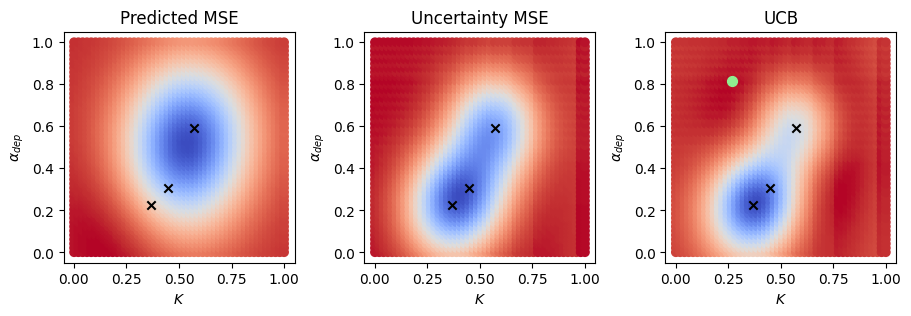


----------------- Iteration exp. 16 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 287.78it/s, init loss: 13190.5547, avg. loss [951-1000]: 12472.3336]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2348
noise            0.0535
16

----------------- Iteration theory 16 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.61it/s, init loss: 13232.8828, avg. loss [951-1000]: 12535.1298]



Inferred GP kernel parameters
k_length         [0.36789998 0.33069998 0.36789998]
k_scale          0.36249998
noise            0.1083
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.17it/s]



----------------- Iteration exp. 17 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 279.43it/s, init loss: 13191.4844, avg. loss [951-1000]: 12472.0128]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2356
noise            0.0523
17

----------------- Iteration theory 17 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.06it/s, init loss: 13232.9639, avg. loss [951-1000]: 12535.1248]



Inferred GP kernel parameters
k_length         [0.36789998 0.32549998 0.36789998]
k_scale          0.3579
noise            0.101799995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.56it/s]



----------------- Iteration exp. 18 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 277.78it/s, init loss: 13192.3936, avg. loss [951-1000]: 12471.5178]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2351
noise            0.050499998
18

----------------- Iteration theory 18 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 536.11it/s, init loss: 13232.8105, avg. loss [951-1000]: 12535.0133]



Inferred GP kernel parameters
k_length         [0.36789998 0.3233     0.36789998]
k_scale          0.3705
noise            0.0985
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.32it/s]



----------------- Iteration exp. 19 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 276.81it/s, init loss: 13193.2715, avg. loss [951-1000]: 12470.9951]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2348
noise            0.0488
19

----------------- Iteration theory 19 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 534.71it/s, init loss: 13233.1523, avg. loss [951-1000]: 12535.1204]



Inferred GP kernel parameters
k_length         [0.36789998 0.32909998 0.36789998]
k_scale          0.3681
noise            0.1064
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.53it/s]



----------------- Iteration exp. 20 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 286.34it/s, init loss: 13194.1855, avg. loss [951-1000]: 12470.5815]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2341
noise            0.0477
20

----------------- Iteration theory 20 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.16it/s, init loss: 13233.2451, avg. loss [951-1000]: 12535.3181]



Inferred GP kernel parameters
k_length         [0.36789998 0.3284     0.36789998]
k_scale          0.4172
noise            0.0982
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.52it/s]



----------------- Theory model tune iter_20 -----------------

MSE 3.86
UCB beta =  99.945
3.8606801629066467


100%|██████████| 250/250 [00:00<00:00, 375.23it/s, init loss: 7.0013, avg. loss [229-240]: 5.4372]



Inferred GP parameters
k_length         [0.2129 0.3057]
k_scale          0.6497
noise            0.2865
6.001749 3.2001703


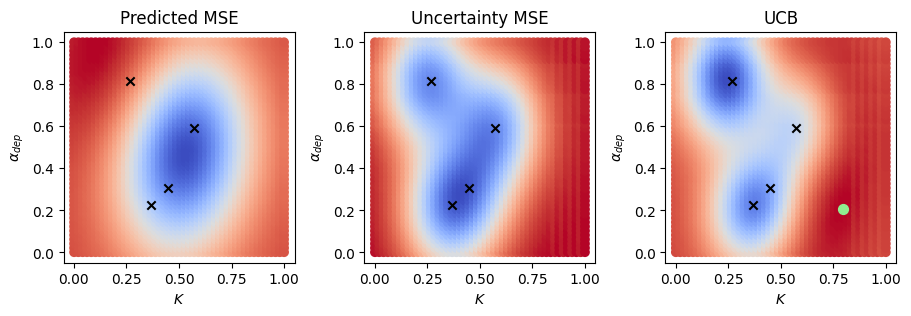


----------------- Iteration exp. 21 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 281.24it/s, init loss: 13195.2646, avg. loss [951-1000]: 12469.7516]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2357
noise            0.0453
21

----------------- Iteration theory 21 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.53it/s, init loss: 13233.2451, avg. loss [951-1000]: 12535.3179]



Inferred GP kernel parameters
k_length         [0.36789998 0.3284     0.36789998]
k_scale          0.4172
noise            0.0982
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.68it/s]



----------------- Iteration exp. 22 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 262.95it/s, init loss: 13196.3271, avg. loss [951-1000]: 12469.1221]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2357
noise            0.0438
22

----------------- Iteration theory 22 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.49it/s, init loss: 13233.1523, avg. loss [951-1000]: 12535.1205]



Inferred GP kernel parameters
k_length         [0.36789998 0.3288     0.36789998]
k_scale          0.3683
noise            0.1064
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.54it/s]



----------------- Iteration exp. 23 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 209.53it/s, init loss: 13197.3027, avg. loss [951-1000]: 12468.5014]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2355
noise            0.0424
23

----------------- Iteration theory 23 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.35it/s, init loss: 13232.9736, avg. loss [951-1000]: 12535.2192]



Inferred GP kernel parameters
k_length         [0.36789998 0.3295     0.36789998]
k_scale          0.378
noise            0.104399994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.43it/s]



----------------- Iteration exp. 24 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.80it/s, init loss: 13198.1709, avg. loss [951-1000]: 12467.8705]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23519999
noise            0.0412
24

----------------- Iteration theory 24 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 509.31it/s, init loss: 13232.7256, avg. loss [951-1000]: 12535.2392]



Inferred GP kernel parameters
k_length         [0.36789998 0.3224     0.36789998]
k_scale          0.3987
noise            0.0927
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.43it/s]



----------------- Iteration exp. 25 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 218.48it/s, init loss: 13199.0459, avg. loss [951-1000]: 12467.1986]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2351
noise            0.04
25

----------------- Iteration theory 25 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.40it/s, init loss: 13232.9629, avg. loss [951-1000]: 12535.2788]



Inferred GP kernel parameters
k_length         [0.36789998 0.3144     0.36789998]
k_scale          0.4105
noise            0.0876
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.55it/s]



----------------- Theory model tune iter_25 -----------------

MSE 3.84
UCB beta =  99.807
3.8606801629066467


100%|██████████| 250/250 [00:00<00:00, 357.75it/s, init loss: 8.2608, avg. loss [229-240]: 6.3584]



Inferred GP parameters
k_length         [0.1899 0.3013]
k_scale          0.57049996
noise            0.2733
5.404367 2.9900527


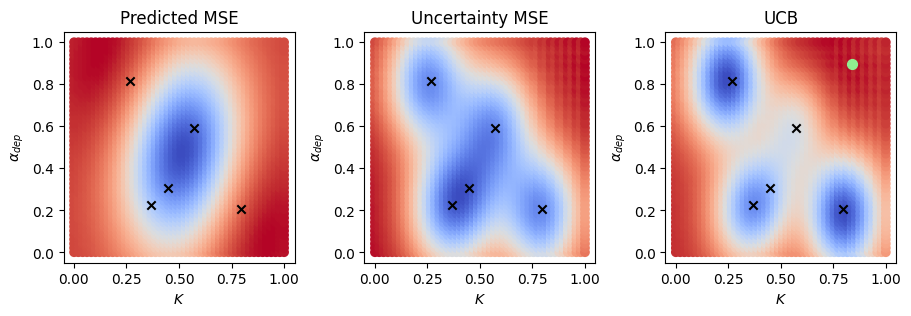


----------------- Iteration exp. 26 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 224.71it/s, init loss: 13199.9014, avg. loss [951-1000]: 12466.5233]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2349
noise            0.0389
26

----------------- Iteration theory 26 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 523.16it/s, init loss: 13233.1426, avg. loss [951-1000]: 12535.3399]



Inferred GP kernel parameters
k_length         [0.36789998 0.3091     0.36789998]
k_scale          0.4121
noise            0.089499995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.54it/s]



----------------- Iteration exp. 27 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 219.03it/s, init loss: 13200.7480, avg. loss [951-1000]: 12465.8733]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2347
noise            0.0379
27

----------------- Iteration theory 27 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 528.61it/s, init loss: 13233.1426, avg. loss [951-1000]: 12535.3473]



Inferred GP kernel parameters
k_length         [0.36789998 0.3046     0.36789998]
k_scale          0.41369998
noise            0.0888
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.06it/s]



----------------- Iteration exp. 28 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 223.28it/s, init loss: 13201.6016, avg. loss [951-1000]: 12465.2088]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23439999
noise            0.037
28

----------------- Iteration theory 28 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.26it/s, init loss: 13233.2285, avg. loss [951-1000]: 12535.0889]



Inferred GP kernel parameters
k_length         [0.36789998 0.30629998 0.36789998]
k_scale          0.3735
noise            0.096099995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.03it/s]



----------------- Iteration exp. 29 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 220.11it/s, init loss: 13202.4463, avg. loss [951-1000]: 12464.4799]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23429999
noise            0.036
29

----------------- Iteration theory 29 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.04it/s, init loss: 13233.2891, avg. loss [951-1000]: 12535.1436]



Inferred GP kernel parameters
k_length         [0.36789998 0.3191     0.36789998]
k_scale          0.3734
noise            0.104899995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.87it/s]



----------------- Iteration exp. 30 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 222.40it/s, init loss: 13203.3164, avg. loss [951-1000]: 12463.7304]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23429999
noise            0.035099998
30

----------------- Iteration theory 30 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.21it/s, init loss: 13233.2031, avg. loss [951-1000]: 12535.3641]



Inferred GP kernel parameters
k_length         [0.36789998 0.32       0.36789998]
k_scale          0.41849998
noise            0.0971
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.09it/s]



----------------- Theory model tune iter_30 -----------------

MSE 3.31
UCB beta =  99.331
3.8606801629066467


100%|██████████| 250/250 [00:00<00:00, 347.28it/s, init loss: 9.3353, avg. loss [229-240]: 7.2125]



Inferred GP parameters
k_length         [0.20199999 0.3112    ]
k_scale          0.5216
noise            0.2497
4.8679466 2.672176


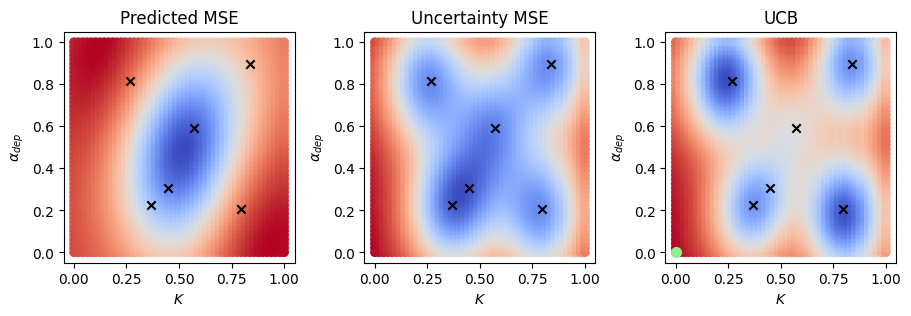


----------------- Iteration exp. 31 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 224.10it/s, init loss: 13204.1553, avg. loss [951-1000]: 12462.9814]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2342
noise            0.0343
31

----------------- Iteration theory 31 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 518.15it/s, init loss: 13232.9414, avg. loss [951-1000]: 12535.3358]



Inferred GP kernel parameters
k_length         [0.36789998 0.31219998 0.36789998]
k_scale          0.42749998
noise            0.085999995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.18it/s]



----------------- Iteration exp. 32 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 224.62it/s, init loss: 13205.0830, avg. loss [951-1000]: 12462.2042]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2342
noise            0.0334
32

----------------- Iteration theory 32 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.80it/s, init loss: 13232.8135, avg. loss [951-1000]: 12535.0718]



Inferred GP kernel parameters
k_length         [0.36789998 0.312      0.36789998]
k_scale          0.3732
noise            0.1008
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.16it/s]



----------------- Iteration exp. 33 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 214.48it/s, init loss: 13206.0342, avg. loss [951-1000]: 12461.4961]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.234
noise            0.0328
33

----------------- Iteration theory 33 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.68it/s, init loss: 13233.0039, avg. loss [951-1000]: 12535.2318]



Inferred GP kernel parameters
k_length         [0.36789998 0.30449998 0.36789998]
k_scale          0.375
noise            0.095199995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.64it/s]



----------------- Iteration exp. 34 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 219.14it/s, init loss: 13207.0576, avg. loss [951-1000]: 12460.9334]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23369999
noise            0.0324
34

----------------- Iteration theory 34 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.71it/s, init loss: 13233.3174, avg. loss [951-1000]: 12535.2713]



Inferred GP kernel parameters
k_length         [0.36789998 0.3144     0.36789998]
k_scale          0.3883
noise            0.101399995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.84it/s]



----------------- Iteration exp. 35 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 217.56it/s, init loss: 13207.9268, avg. loss [951-1000]: 12460.1507]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23349999
noise            0.0317
35

----------------- Iteration theory 35 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.98it/s, init loss: 13233.6758, avg. loss [951-1000]: 12535.1530]



Inferred GP kernel parameters
k_length         [0.36789998 0.31419998 0.36789998]
k_scale          0.39609998
noise            0.0986
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.75it/s]



----------------- Theory model tune iter_35 -----------------

MSE 3.28
UCB beta =  97.702
3.8606801629066467


100%|██████████| 250/250 [00:00<00:00, 337.03it/s, init loss: 10.4343, avg. loss [229-240]: 8.1894]



Inferred GP parameters
k_length         [0.2119     0.30879998]
k_scale          0.48299998
noise            0.2462
4.3816147 2.5720708


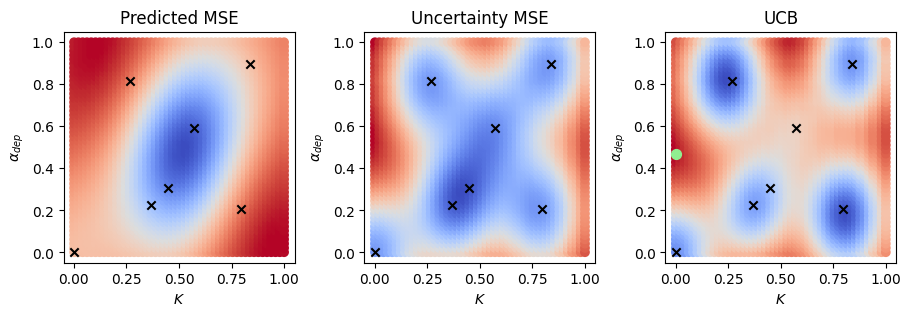


----------------- Iteration exp. 36 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 215.67it/s, init loss: 13208.7627, avg. loss [951-1000]: 12459.3371]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23349999
noise            0.031
36

----------------- Iteration theory 36 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 499.92it/s, init loss: 13233.5146, avg. loss [951-1000]: 12535.0335]



Inferred GP kernel parameters
k_length         [0.36789998 0.32549998 0.36789998]
k_scale          0.3734
noise            0.1083
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.55it/s]



----------------- Iteration exp. 37 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 218.69it/s, init loss: 13209.5830, avg. loss [951-1000]: 12458.5071]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23349999
noise            0.030399999
37

----------------- Iteration theory 37 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.52it/s, init loss: 13233.6895, avg. loss [951-1000]: 12535.0501]



Inferred GP kernel parameters
k_length         [0.36789998 0.32909998 0.36789998]
k_scale          0.39209998
noise            0.098
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.37it/s]



----------------- Iteration exp. 38 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 227.17it/s, init loss: 13210.4590, avg. loss [951-1000]: 12457.7658]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23369999
noise            0.0299
38

----------------- Iteration theory 38 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.68it/s, init loss: 13233.4805, avg. loss [951-1000]: 12535.3178]



Inferred GP kernel parameters
k_length         [0.36789998 0.3231     0.36789998]
k_scale          0.4034
noise            0.0975
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.14it/s]



----------------- Iteration exp. 39 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 217.33it/s, init loss: 13211.3018, avg. loss [951-1000]: 12457.1898]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.234
noise            0.0296
39

----------------- Iteration theory 39 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.43it/s, init loss: 13233.4902, avg. loss [951-1000]: 12535.1606]



Inferred GP kernel parameters
k_length         [0.36789998 0.318      0.36789998]
k_scale          0.3818
noise            0.091
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 130.20it/s]



----------------- Iteration exp. 40 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 226.55it/s, init loss: 13212.1123, avg. loss [951-1000]: 12456.6179]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23439999
noise            0.029299999
40

----------------- Iteration theory 40 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 516.24it/s, init loss: 13233.2803, avg. loss [951-1000]: 12535.1999]



Inferred GP kernel parameters
k_length         [0.36789998 0.36319998 0.3275    ]
k_scale          0.38529998
noise            0.0984
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.95it/s]



----------------- Theory model tune iter_40 -----------------

MSE 4.14
UCB beta =  92.414
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 340.75it/s, init loss: 12.0403, avg. loss [229-240]: 9.9785]



Inferred GP parameters
k_length         [0.253  0.3545]
k_scale          0.59029996
noise            0.2323
3.974517 1.9362512


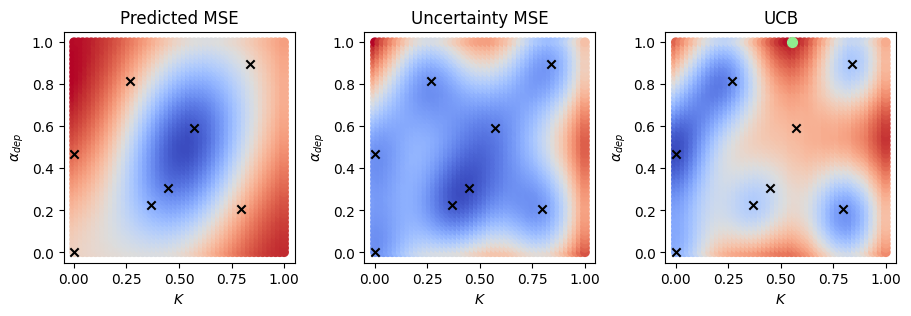


----------------- Iteration exp. 41 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.49it/s, init loss: 13213.0430, avg. loss [951-1000]: 12456.1407]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2348
noise            0.029199999
41

----------------- Iteration theory 41 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.05it/s, init loss: 13233.3076, avg. loss [951-1000]: 12535.1944]



Inferred GP kernel parameters
k_length         [0.36789998 0.32819998 0.36789998]
k_scale          0.38819999
noise            0.0967
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.75it/s]



----------------- Iteration exp. 42 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 227.29it/s, init loss: 13213.8945, avg. loss [951-1000]: 12455.3944]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23449999
noise            0.0288
0

----------------- Iteration theory 42 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 526.84it/s, init loss: 13233.4854, avg. loss [951-1000]: 12535.2436]



Inferred GP kernel parameters
k_length         [0.36789998 0.318      0.36789998]
k_scale          0.39
noise            0.096599996
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.98it/s]



----------------- Iteration exp. 43 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 216.63it/s, init loss: 13214.7441, avg. loss [951-1000]: 12454.7370]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23429999
noise            0.0284
0

----------------- Iteration theory 43 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 529.85it/s, init loss: 13233.4854, avg. loss [951-1000]: 12535.3177]



Inferred GP kernel parameters
k_length         [0.36789998 0.2997     0.36789998]
k_scale          0.39479998
noise            0.0968
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.86it/s]



----------------- Iteration exp. 44 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 222.30it/s, init loss: 13215.5791, avg. loss [951-1000]: 12454.0682]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.234
noise            0.028099999
0

----------------- Iteration theory 44 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.19it/s, init loss: 13233.2705, avg. loss [951-1000]: 12535.1172]



Inferred GP kernel parameters
k_length         [0.36789998 0.3134     0.36789998]
k_scale          0.37449998
noise            0.104499996
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.94it/s]



----------------- Iteration exp. 45 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 213.27it/s, init loss: 13216.4023, avg. loss [951-1000]: 12453.3887]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2338
noise            0.0278
42

----------------- Iteration theory 45 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.39it/s, init loss: 13233.0859, avg. loss [951-1000]: 12535.3956]



Inferred GP kernel parameters
k_length         [0.36789998 0.3281     0.36789998]
k_scale          0.2932
noise            0.16759999
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.78it/s]



----------------- Theory model tune iter_45 -----------------

MSE 3.62
UCB beta =  77.73
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 321.77it/s, init loss: 13.0465, avg. loss [229-240]: 10.6371]



Inferred GP parameters
k_length         [0.273      0.34219998]
k_scale          0.5539
noise            0.21419999
3.0222979 1.2329879


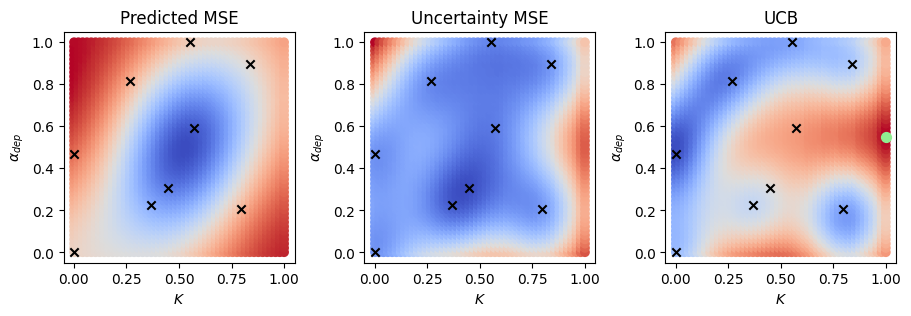


----------------- Iteration exp. 46 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 225.89it/s, init loss: 13217.2197, avg. loss [951-1000]: 12452.5246]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23369999
noise            0.0274
43

----------------- Iteration theory 46 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.54it/s, init loss: 13233.2002, avg. loss [951-1000]: 12535.1584]



Inferred GP kernel parameters
k_length         [0.36789998 0.3238     0.36789998]
k_scale          0.3664
noise            0.104499996
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.11it/s]



----------------- Iteration exp. 47 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 223.11it/s, init loss: 13218.0264, avg. loss [951-1000]: 12451.6910]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23349999
noise            0.026999999
0

----------------- Iteration theory 47 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.42it/s, init loss: 13232.9932, avg. loss [951-1000]: 12535.2010]



Inferred GP kernel parameters
k_length         [0.36789998 0.3287     0.36789998]
k_scale          0.36949998
noise            0.1063
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.40it/s]



----------------- Iteration exp. 48 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 219.29it/s, init loss: 13218.8418, avg. loss [951-1000]: 12450.9840]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2333
noise            0.0267
44

----------------- Iteration theory 48 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.10it/s, init loss: 13232.9062, avg. loss [951-1000]: 12535.1578]



Inferred GP kernel parameters
k_length         [0.36789998 0.3231     0.36789998]
k_scale          0.3698
noise            0.098699994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.59it/s]



----------------- Iteration exp. 49 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 215.23it/s, init loss: 13219.6660, avg. loss [951-1000]: 12450.4103]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.233
noise            0.0266
0

----------------- Iteration theory 49 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 528.73it/s, init loss: 13233.0850, avg. loss [951-1000]: 12535.1893]



Inferred GP kernel parameters
k_length         [0.3187     0.3635     0.36789998]
k_scale          0.3716
noise            0.098299995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.85it/s]



----------------- Iteration exp. 50 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 220.27it/s, init loss: 13220.4746, avg. loss [951-1000]: 12449.6828]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23279999
noise            0.0263
45

----------------- Iteration theory 50 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 518.77it/s, init loss: 13233.3613, avg. loss [951-1000]: 12535.1679]



Inferred GP kernel parameters
k_length         [0.36789998 0.3205     0.36789998]
k_scale          0.3716
noise            0.103999995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.86it/s]



----------------- Theory model tune iter_50 -----------------

MSE 3.67
UCB beta =  50.0
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 252.07it/s, init loss: 14.0797, avg. loss [229-240]: 11.2735]



Inferred GP parameters
k_length         [0.2839     0.35119998]
k_scale          0.5225
noise            0.19559999
1.3635168 -0.0024938583


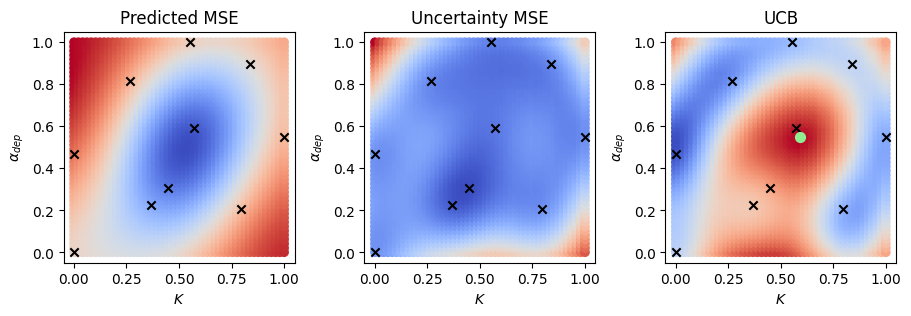


----------------- Iteration exp. 51 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 224.53it/s, init loss: 13221.4238, avg. loss [951-1000]: 12448.8360]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23279999
noise            0.025999999
0

----------------- Iteration theory 51 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 530.67it/s, init loss: 13233.2725, avg. loss [951-1000]: 12535.3510]



Inferred GP kernel parameters
k_length         [0.36789998 0.3205     0.36789998]
k_scale          0.41869998
noise            0.0977
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.75it/s]



----------------- Iteration exp. 52 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.52it/s, init loss: 13222.2275, avg. loss [951-1000]: 12448.0903]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0257
46

----------------- Iteration theory 52 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 530.92it/s, init loss: 13233.3613, avg. loss [951-1000]: 12535.1680]



Inferred GP kernel parameters
k_length         [0.36789998 0.3207     0.36789998]
k_scale          0.3715
noise            0.103999995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.22it/s]



----------------- Iteration exp. 53 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 221.73it/s, init loss: 13223.1631, avg. loss [951-1000]: 12447.1676]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0253
47

----------------- Iteration theory 53 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 513.59it/s, init loss: 13233.4199, avg. loss [951-1000]: 12535.2463]



Inferred GP kernel parameters
k_length         [0.36789998 0.3214     0.36789998]
k_scale          0.38709998
noise            0.0994
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.63it/s]



----------------- Iteration exp. 54 -----------------



100%|██████████| 1000/1000 [00:04<00:00, 237.74it/s, init loss: 13224.0264, avg. loss [951-1000]: 12446.2284]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.024999999
48

----------------- Iteration theory 54 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.07it/s, init loss: 13233.2422, avg. loss [951-1000]: 12535.2050]



Inferred GP kernel parameters
k_length         [0.36789998 0.3285     0.36789998]
k_scale          0.3827
noise            0.1003
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.66it/s]



----------------- Iteration exp. 55 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.72it/s, init loss: 13224.8486, avg. loss [951-1000]: 12445.2798]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0246
49

----------------- Iteration theory 55 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.46it/s, init loss: 13233.1445, avg. loss [951-1000]: 12535.2113]



Inferred GP kernel parameters
k_length         [0.36789998 0.3664     0.3296    ]
k_scale          0.38979998
noise            0.0981
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 128.05it/s]



----------------- Theory model tune iter_55 -----------------

MSE 3.88
UCB beta =  22.271
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 254.24it/s, init loss: 15.3005, avg. loss [229-240]: 13.2619]



Inferred GP parameters
k_length         [0.3209 0.3972]
k_scale          0.3714
noise            0.3775
0.18222094 -0.49490213


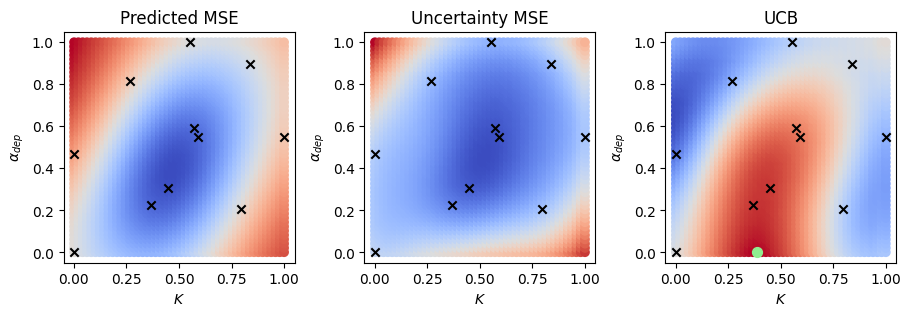


----------------- Iteration exp. 56 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 173.89it/s, init loss: 13225.6582, avg. loss [951-1000]: 12444.3244]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0242
50

----------------- Iteration theory 56 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 516.88it/s, init loss: 13233.2617, avg. loss [951-1000]: 12535.1642]



Inferred GP kernel parameters
k_length         [0.36789998 0.329      0.36789998]
k_scale          0.37489998
noise            0.1019
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.90it/s]



----------------- Iteration exp. 57 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.50it/s, init loss: 13226.4619, avg. loss [951-1000]: 12443.3673]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23249999
noise            0.023899999
51

----------------- Iteration theory 57 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.06it/s, init loss: 13233.1436, avg. loss [951-1000]: 12535.1604]



Inferred GP kernel parameters
k_length         [0.36789998 0.3279     0.36789998]
k_scale          0.34309998
noise            0.1217
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.82it/s]



----------------- Iteration exp. 58 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 166.02it/s, init loss: 13227.2979, avg. loss [951-1000]: 12442.4163]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.023599999
0

----------------- Iteration theory 58 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.32it/s, init loss: 13232.8867, avg. loss [951-1000]: 12535.1756]



Inferred GP kernel parameters
k_length         [0.36789998 0.3267     0.36789998]
k_scale          0.3405
noise            0.1149
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 128.05it/s]



----------------- Iteration exp. 59 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.26it/s, init loss: 13228.0928, avg. loss [951-1000]: 12441.6323]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23249999
noise            0.0234
52

----------------- Iteration theory 59 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.85it/s, init loss: 13233.1172, avg. loss [951-1000]: 12535.1329]



Inferred GP kernel parameters
k_length         [0.36789998 0.33089998 0.36789998]
k_scale          0.3484
noise            0.1182
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 128.11it/s]



----------------- Iteration exp. 60 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 164.40it/s, init loss: 13228.9561, avg. loss [951-1000]: 12440.7322]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0231
0

----------------- Iteration theory 60 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.87it/s, init loss: 13232.9277, avg. loss [951-1000]: 12535.1935]



Inferred GP kernel parameters
k_length         [0.36789998 0.3311     0.36789998]
k_scale          0.343
noise            0.1192
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.05it/s]



----------------- Theory model tune iter_60 -----------------

MSE 3.59
UCB beta =  7.587
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 254.85it/s, init loss: 16.3016, avg. loss [229-240]: 13.9236]



Inferred GP parameters
k_length         [0.32529998 0.39299998]
k_scale          0.34849998
noise            0.3568
-1.2792302 -2.0383976


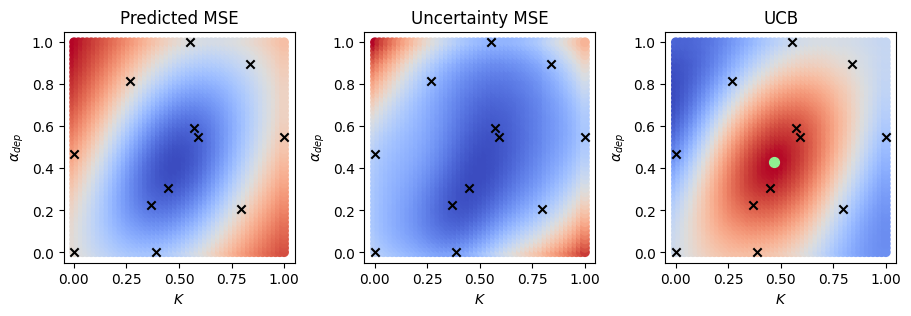


----------------- Iteration exp. 61 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 165.13it/s, init loss: 13229.7471, avg. loss [951-1000]: 12439.9396]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2324
noise            0.023
0

----------------- Iteration theory 61 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.03it/s, init loss: 13232.8564, avg. loss [951-1000]: 12535.1150]



Inferred GP kernel parameters
k_length         [0.36789998 0.3292     0.36789998]
k_scale          0.3664
noise            0.1072
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.42it/s]



----------------- Iteration exp. 62 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 176.68it/s, init loss: 13230.5361, avg. loss [951-1000]: 12439.1390]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.022799999
0

----------------- Iteration theory 62 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.92it/s, init loss: 13232.8926, avg. loss [951-1000]: 12535.1311]



Inferred GP kernel parameters
k_length         [0.36789998 0.3304     0.36789998]
k_scale          0.3638
noise            0.1073
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.30it/s]



----------------- Iteration exp. 63 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.22it/s, init loss: 13231.3223, avg. loss [951-1000]: 12438.3316]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2321
noise            0.022599999
0

----------------- Iteration theory 63 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 522.56it/s, init loss: 13233.0508, avg. loss [951-1000]: 12535.3569]



Inferred GP kernel parameters
k_length         [0.36789998 0.3296     0.36789998]
k_scale          0.4134
noise            0.099599995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.66it/s]



----------------- Iteration exp. 64 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 171.47it/s, init loss: 13232.1074, avg. loss [951-1000]: 12437.5144]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.232
noise            0.0224
53

----------------- Iteration theory 64 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.23it/s, init loss: 13233.0146, avg. loss [951-1000]: 12535.3484]



Inferred GP kernel parameters
k_length         [0.36789998 0.3293     0.36789998]
k_scale          0.41419998
noise            0.0982
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.56it/s]



----------------- Iteration exp. 65 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.11it/s, init loss: 13232.9707, avg. loss [951-1000]: 12436.6635]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2321
noise            0.0222
54

----------------- Iteration theory 65 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.10it/s, init loss: 13232.9922, avg. loss [951-1000]: 12535.3168]



Inferred GP kernel parameters
k_length         [0.36789998 0.3293     0.36789998]
k_scale          0.4348
noise            0.092999995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.31it/s]



----------------- Theory model tune iter_65 -----------------

MSE 3.44
UCB beta =  2.299
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 251.42it/s, init loss: 17.2391, avg. loss [229-240]: 14.5458]



Inferred GP parameters
k_length         [0.33699998 0.4055    ]
k_scale          0.327
noise            0.34379998
-2.2098851 -2.9969437


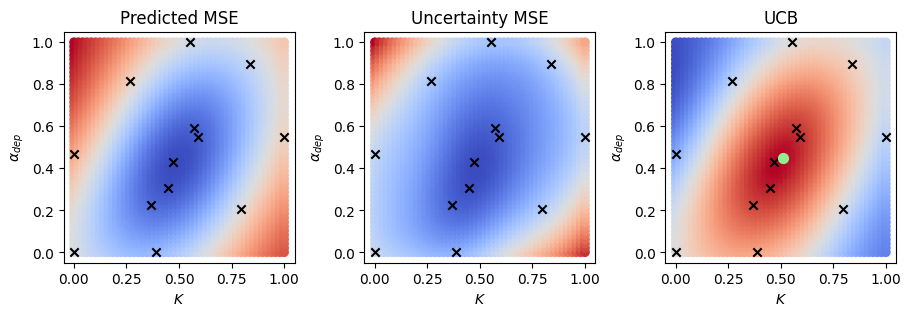


----------------- Iteration exp. 66 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 180.62it/s, init loss: 13233.8154, avg. loss [951-1000]: 12435.6550]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2324
noise            0.022
55

----------------- Iteration theory 66 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.40it/s, init loss: 13232.9922, avg. loss [951-1000]: 12535.3168]



Inferred GP kernel parameters
k_length         [0.36789998 0.3293     0.36789998]
k_scale          0.4348
noise            0.092999995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.74it/s]



----------------- Iteration exp. 67 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 158.30it/s, init loss: 13234.6729, avg. loss [951-1000]: 12434.6404]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2321
noise            0.021699999
56

----------------- Iteration theory 67 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 525.67it/s, init loss: 13233.0146, avg. loss [951-1000]: 12535.3485]



Inferred GP kernel parameters
k_length         [0.36789998 0.3293     0.36789998]
k_scale          0.41419998
noise            0.0982
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.99it/s]



----------------- Iteration exp. 68 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 170.32it/s, init loss: 13235.4629, avg. loss [951-1000]: 12433.6151]



Inferred GP kernel parameters
k_length         [0.3678     0.36789998]
k_scale          0.23259999
noise            0.021499999
0

----------------- Iteration theory 68 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.65it/s, init loss: 13233.0000, avg. loss [951-1000]: 12535.3029]



Inferred GP kernel parameters
k_length         [0.36789998 0.3296     0.36789998]
k_scale          0.4064
noise            0.0982
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.98it/s]



----------------- Iteration exp. 69 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 155.74it/s, init loss: 13236.2441, avg. loss [951-1000]: 12391.9612]



Inferred GP kernel parameters
k_length         [0.14019999 0.3615    ]
k_scale          0.3294
noise            0.0072999997
1920

----------------- Iteration theory 69 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 355.69it/s, init loss: 13232.7393, avg. loss [951-1000]: 12535.2092]



Inferred GP kernel parameters
k_length         [0.36789998 0.3211     0.36789998]
k_scale          0.413
noise            0.0853
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.32it/s]



----------------- Iteration exp. 70 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 175.66it/s, init loss: 13237.0459, avg. loss [951-1000]: 12431.8997]



Inferred GP kernel parameters
k_length         [0.368      0.36789998]
k_scale          0.23189999
noise            0.0212
57

----------------- Iteration theory 70 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.08it/s, init loss: 13232.9854, avg. loss [951-1000]: 12535.3218]



Inferred GP kernel parameters
k_length         [0.36789998 0.32619998 0.36789998]
k_scale          0.413
noise            0.095199995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.31it/s]



----------------- Theory model tune iter_70 -----------------

MSE 3.37
UCB beta =  0.67
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 249.20it/s, init loss: 18.1491, avg. loss [229-240]: 15.0483]



Inferred GP parameters
k_length         [0.3444 0.413 ]
k_scale          0.3164
noise            0.32279998
-2.7039092 -3.5418248


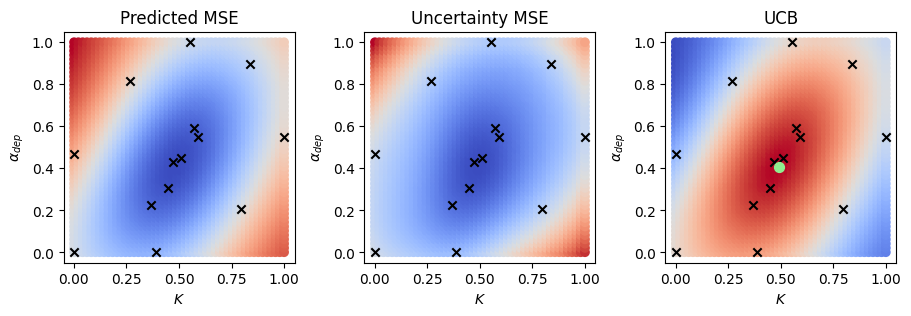


----------------- Iteration exp. 71 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 169.37it/s, init loss: 13237.9941, avg. loss [951-1000]: 12397.8103]



Inferred GP kernel parameters
k_length         [0.1546     0.36769998]
k_scale          0.3595
noise            0.0084999995
0

----------------- Iteration theory 71 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.89it/s, init loss: 13233.2344, avg. loss [951-1000]: 12535.2875]



Inferred GP kernel parameters
k_length         [0.36789998 0.3287     0.36789998]
k_scale          0.42
noise            0.097799994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.09it/s]



----------------- Iteration exp. 72 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 174.38it/s, init loss: 13238.7734, avg. loss [951-1000]: 12431.3766]



Inferred GP kernel parameters
k_length         [0.1573 0.3444]
k_scale          0.2464
noise            0.016099999
58

----------------- Iteration theory 72 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.35it/s, init loss: 13233.2344, avg. loss [951-1000]: 12535.2914]



Inferred GP kernel parameters
k_length         [0.3678     0.35979998 0.3353    ]
k_scale          0.42
noise            0.097899996
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 128.05it/s]



----------------- Iteration exp. 73 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 168.52it/s, init loss: 13239.6289, avg. loss [951-1000]: 12429.3009]



Inferred GP kernel parameters
k_length         [0.3672     0.36789998]
k_scale          0.2331
noise            0.0206
59

----------------- Iteration theory 73 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 509.53it/s, init loss: 13233.1416, avg. loss [951-1000]: 12535.0997]



Inferred GP kernel parameters
k_length         [0.36789998 0.33069998 0.36789998]
k_scale          0.3696
noise            0.107999995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.27it/s]



----------------- Iteration exp. 74 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 169.35it/s, init loss: 13240.7021, avg. loss [951-1000]: 12382.7282]



Inferred GP kernel parameters
k_length         [0.2295 0.3572]
k_scale          0.3608
noise            0.0075999997
0

----------------- Iteration theory 74 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 500.69it/s, init loss: 13233.1338, avg. loss [951-1000]: 12535.0966]



Inferred GP kernel parameters
k_length         [0.36789998 0.32999998 0.36789998]
k_scale          0.36969998
noise            0.10789999
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.56it/s]



----------------- Iteration exp. 75 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 159.23it/s, init loss: 13241.4805, avg. loss [951-1000]: 12427.6895]



Inferred GP kernel parameters
k_length         [0.3678     0.36789998]
k_scale          0.23179999
noise            0.020499999
0

----------------- Iteration theory 75 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 527.41it/s, init loss: 13233.0273, avg. loss [951-1000]: 12535.3601]



Inferred GP kernel parameters
k_length         [0.36789998 0.3288     0.36789998]
k_scale          0.4141
noise            0.099
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.99it/s]



----------------- Theory model tune iter_75 -----------------

MSE 3.17
UCB beta =  0.194
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 243.35it/s, init loss: 19.0481, avg. loss [229-240]: 15.4538]



Inferred GP parameters
k_length         [0.3445 0.4168]
k_scale          0.3153
noise            0.2976
-2.9355545 -3.8405488


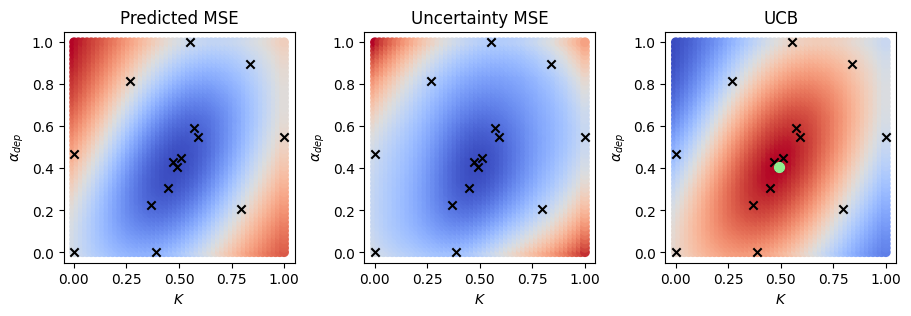


----------------- Iteration exp. 76 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.11it/s, init loss: 13242.2578, avg. loss [951-1000]: 12426.8080]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2315
noise            0.020399999
0

----------------- Iteration theory 76 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.06it/s, init loss: 13232.7617, avg. loss [951-1000]: 12535.2623]



Inferred GP kernel parameters
k_length         [0.36789998 0.3208     0.36789998]
k_scale          0.4243
noise            0.085
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.41it/s]



----------------- Iteration exp. 77 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 163.20it/s, init loss: 13243.0342, avg. loss [951-1000]: 12425.9208]



Inferred GP kernel parameters
k_length         [0.3669     0.36789998]
k_scale          0.2329
noise            0.0202
60

----------------- Iteration theory 77 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.52it/s, init loss: 13232.9570, avg. loss [951-1000]: 12535.3151]



Inferred GP kernel parameters
k_length         [0.36789998 0.3241     0.36789998]
k_scale          0.4303
noise            0.0897
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.55it/s]



----------------- Iteration exp. 78 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 171.75it/s, init loss: 13244.1045, avg. loss [951-1000]: 12376.7833]



Inferred GP kernel parameters
k_length         [0.19559999 0.3678    ]
k_scale          0.27809998
noise            0.0074
829

----------------- Iteration theory 78 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 524.21it/s, init loss: 13232.9883, avg. loss [951-1000]: 12535.3503]



Inferred GP kernel parameters
k_length         [0.36789998 0.322      0.36789998]
k_scale          0.4367
noise            0.092599995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.60it/s]



----------------- Iteration exp. 79 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 157.01it/s, init loss: 13245.0176, avg. loss [951-1000]: 12426.2120]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23169999
noise            0.0208
0

----------------- Iteration theory 79 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.62it/s, init loss: 13233.1904, avg. loss [951-1000]: 12535.3596]



Inferred GP kernel parameters
k_length         [0.36789998 0.3218     0.36789998]
k_scale          0.41709998
noise            0.0968
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.59it/s]



----------------- Iteration exp. 80 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 173.83it/s, init loss: 13245.7920, avg. loss [951-1000]: 12379.5399]



Inferred GP kernel parameters
k_length         [0.18779999 0.3678    ]
k_scale          0.3111
noise            0.0077
0

----------------- Iteration theory 80 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 512.16it/s, init loss: 13233.5742, avg. loss [951-1000]: 12535.3523]



Inferred GP kernel parameters
k_length         [0.36789998 0.322      0.36789998]
k_scale          0.41579998
noise            0.096599996
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.94it/s]



----------------- Theory model tune iter_80 -----------------

MSE 3.63
UCB beta =  0.056
4.1440510749816895


100%|██████████| 250/250 [00:00<00:00, 255.50it/s, init loss: 20.0121, avg. loss [229-240]: 16.1126]



Inferred GP parameters
k_length         [0.354  0.4229]
k_scale          0.3015
noise            0.2938
-3.112061 -3.9783084


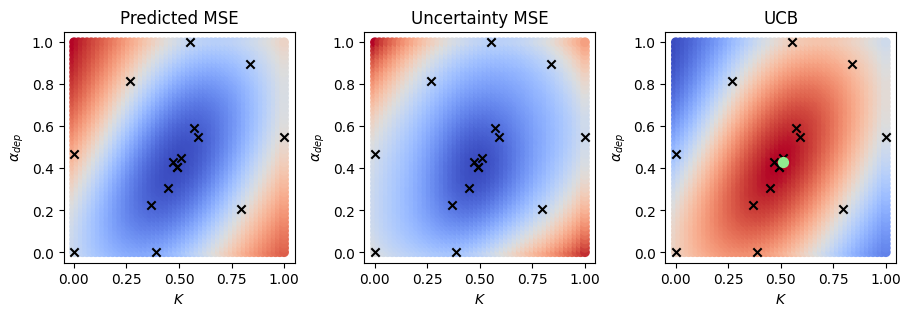


----------------- Iteration exp. 81 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 163.43it/s, init loss: 13246.5664, avg. loss [951-1000]: 12391.0062]



Inferred GP kernel parameters
k_length         [0.2447 0.1415]
k_scale          0.40129998
noise            0.0084999995
2052

----------------- Iteration theory 81 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.46it/s, init loss: 13233.1904, avg. loss [951-1000]: 12535.3589]



Inferred GP kernel parameters
k_length         [0.36789998 0.322      0.36789998]
k_scale          0.41709998
noise            0.0968
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.90it/s]



----------------- Iteration exp. 82 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 174.76it/s, init loss: 13247.4170, avg. loss [951-1000]: 12423.6439]



Inferred GP kernel parameters
k_length         [0.3678     0.36789998]
k_scale          0.23189999
noise            0.020499999
61

----------------- Iteration theory 82 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.64it/s, init loss: 13233.2559, avg. loss [951-1000]: 12535.2839]



Inferred GP kernel parameters
k_length         [0.36789998 0.3304     0.36789998]
k_scale          0.4202
noise            0.0981
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.72it/s]



----------------- Iteration exp. 83 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.32it/s, init loss: 13248.2637, avg. loss [951-1000]: 12422.5868]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23169999
noise            0.020299999
0

----------------- Iteration theory 83 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 520.71it/s, init loss: 13232.9863, avg. loss [951-1000]: 12535.3196]



Inferred GP kernel parameters
k_length         [0.36789998 0.3268     0.36789998]
k_scale          0.4129
noise            0.095199995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.25it/s]



----------------- Iteration exp. 84 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 169.83it/s, init loss: 13249.0371, avg. loss [951-1000]: 12421.6830]



Inferred GP kernel parameters
k_length         [0.36749998 0.36789998]
k_scale          0.23249999
noise            0.0201
0

----------------- Iteration theory 84 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.33it/s, init loss: 13233.0264, avg. loss [951-1000]: 12535.3588]



Inferred GP kernel parameters
k_length         [0.36789998 0.32889998 0.36789998]
k_scale          0.4141
noise            0.099
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.48it/s]



----------------- Iteration exp. 85 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.36it/s, init loss: 13249.8096, avg. loss [951-1000]: 12420.7839]



Inferred GP kernel parameters
k_length         [0.3678     0.36789998]
k_scale          0.23169999
noise            0.02
62

----------------- Iteration theory 85 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.99it/s, init loss: 13233.0166, avg. loss [951-1000]: 12535.3307]



Inferred GP kernel parameters
k_length         [0.36789998 0.3288     0.36789998]
k_scale          0.4095
noise            0.0989
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.63it/s]



----------------- Theory model tune iter_85 -----------------

MSE 3.14
UCB beta =  0.017
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 233.89it/s, init loss: 20.9075, avg. loss [229-240]: 16.4743]



Inferred GP parameters
k_length         [0.35459998 0.4267    ]
k_scale          0.3026
noise            0.27359998
-3.1603591 -4.0654435


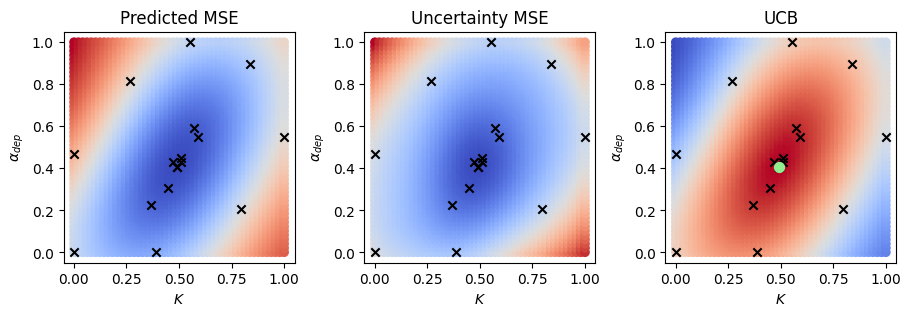


----------------- Iteration exp. 86 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 176.33it/s, init loss: 13250.6533, avg. loss [951-1000]: 12374.8754]



Inferred GP kernel parameters
k_length         [0.1801     0.36789998]
k_scale          0.308
noise            0.007999999
1132

----------------- Iteration theory 86 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 509.35it/s, init loss: 13233.1445, avg. loss [951-1000]: 12535.1345]



Inferred GP kernel parameters
k_length         [0.36789998 0.3312     0.36789998]
k_scale          0.3692
noise            0.1081
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.06it/s]



----------------- Iteration exp. 87 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 159.01it/s, init loss: 13252.0088, avg. loss [951-1000]: 12435.9263]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2323
noise            0.027199998
63

----------------- Iteration theory 87 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.48it/s, init loss: 13233.2012, avg. loss [951-1000]: 12535.2324]



Inferred GP kernel parameters
k_length         [0.36789998 0.3311     0.36789998]
k_scale          0.4173
noise            0.0997
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.16it/s]



----------------- Iteration exp. 88 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.03it/s, init loss: 13252.8184, avg. loss [951-1000]: 12435.0974]



Inferred GP kernel parameters
k_length         [0.3667     0.36789998]
k_scale          0.23429999
noise            0.026899999
64

----------------- Iteration theory 88 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.96it/s, init loss: 13233.2012, avg. loss [951-1000]: 12535.2312]



Inferred GP kernel parameters
k_length         [0.36789998 0.33139998 0.36789998]
k_scale          0.4173
noise            0.099599995
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.76it/s]



----------------- Iteration exp. 89 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 159.49it/s, init loss: 13253.6191, avg. loss [951-1000]: 12434.1655]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23249999
noise            0.0267
0

----------------- Iteration theory 89 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 510.18it/s, init loss: 13232.9600, avg. loss [951-1000]: 12535.3200] 



Inferred GP kernel parameters
k_length         [0.36789998 0.3301     0.36789998]
k_scale          0.4073
noise            0.0994
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.40it/s]



----------------- Iteration exp. 90 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 167.31it/s, init loss: 13254.3926, avg. loss [951-1000]: 12433.4013]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23259999
noise            0.0265
0

----------------- Iteration theory 90 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 521.46it/s, init loss: 13233.0938, avg. loss [951-1000]: 12535.1241]



Inferred GP kernel parameters
k_length         [0.36789998 0.3294     0.36789998]
k_scale          0.37219998
noise            0.106
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.78it/s]



----------------- Theory model tune iter_90 -----------------

MSE 3.27
UCB beta =  0.006
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 229.96it/s, init loss: 21.7862, avg. loss [229-240]: 16.7816]



Inferred GP parameters
k_length         [0.35639998 0.43039998]
k_scale          0.3003
noise            0.2564
-3.1925025 -4.110878


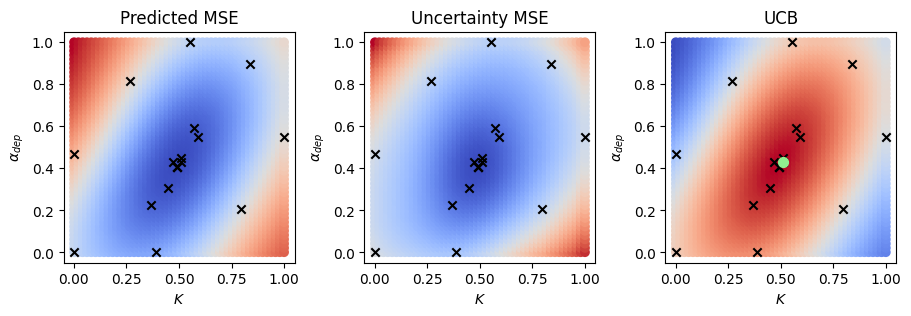


----------------- Iteration exp. 91 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 161.81it/s, init loss: 13255.1650, avg. loss [951-1000]: 12432.6378]



Inferred GP kernel parameters
k_length         [0.3678     0.36789998]
k_scale          0.233
noise            0.0263
65

----------------- Iteration theory 91 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 340.47it/s, init loss: 13232.9814, avg. loss [951-1000]: 12535.3136]



Inferred GP kernel parameters
k_length         [0.36789998 0.3259     0.36789998]
k_scale          0.4125
noise            0.0945
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 126.30it/s]



----------------- Iteration exp. 92 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 162.38it/s, init loss: 13255.9854, avg. loss [951-1000]: 12431.9038]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23279999
noise            0.0262
66

----------------- Iteration theory 92 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 495.91it/s, init loss: 13233.1895, avg. loss [951-1000]: 12535.1340]



Inferred GP kernel parameters
k_length         [0.36789998 0.3295     0.36789998]
k_scale          0.3721
noise            0.1051
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.30it/s]



----------------- Iteration exp. 93 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 158.59it/s, init loss: 13256.8135, avg. loss [951-1000]: 12430.9898]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23249999
noise            0.025999999
67

----------------- Iteration theory 93 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.78it/s, init loss: 13233.2705, avg. loss [951-1000]: 12535.2560]



Inferred GP kernel parameters
k_length         [0.36789998 0.3295     0.36789998]
k_scale          0.4147
noise            0.0977
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.27it/s]



----------------- Iteration exp. 94 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 163.44it/s, init loss: 13257.6641, avg. loss [951-1000]: 12430.1825]



Inferred GP kernel parameters
k_length         [0.3653 0.3676]
k_scale          0.23439999
noise            0.0257
68

----------------- Iteration theory 94 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 518.39it/s, init loss: 13233.2705, avg. loss [951-1000]: 12535.2558]



Inferred GP kernel parameters
k_length         [0.36789998 0.3295     0.36789998]
k_scale          0.4147
noise            0.0977
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.35it/s]



----------------- Iteration exp. 95 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 154.73it/s, init loss: 13258.5352, avg. loss [951-1000]: 12456.0741]



Inferred GP kernel parameters
k_length         [0.1369 0.361 ]
k_scale          0.26299998
noise            0.0162
2393

----------------- Iteration theory 95 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 508.46it/s, init loss: 13233.0732, avg. loss [951-1000]: 12535.3091]



Inferred GP kernel parameters
k_length         [0.36789998 0.32979998 0.36789998]
k_scale          0.4043
noise            0.0993
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.13it/s]



----------------- Theory model tune iter_95 -----------------

MSE 3.17
UCB beta =  0.002
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 226.17it/s, init loss: 22.6674, avg. loss [229-240]: 17.0561]



Inferred GP parameters
k_length         [0.35819998 0.43429998]
k_scale          0.3003
noise            0.24039999
-3.1989493 -4.137201


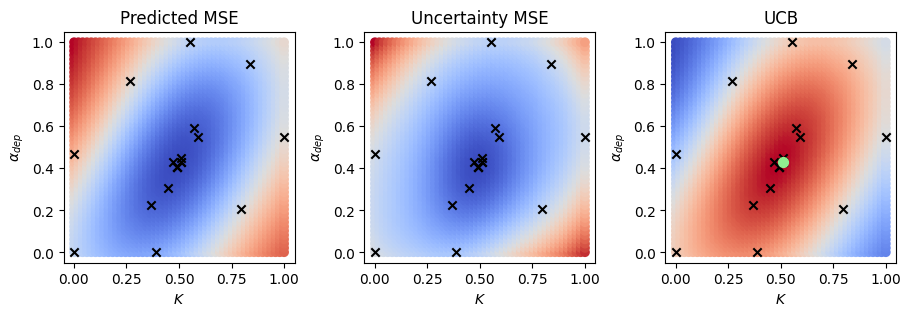


----------------- Iteration exp. 96 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 166.38it/s, init loss: 13259.3594, avg. loss [951-1000]: 12428.2927]



Inferred GP kernel parameters
k_length         [0.368      0.36789998]
k_scale          0.23259999
noise            0.0253
69

----------------- Iteration theory 96 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 514.79it/s, init loss: 13232.9316, avg. loss [951-1000]: 12535.1331]



Inferred GP kernel parameters
k_length         [0.36789998 0.3275     0.36789998]
k_scale          0.35779998
noise            0.104899995
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.79it/s]



----------------- Iteration exp. 97 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 157.05it/s, init loss: 13260.1855, avg. loss [951-1000]: 12427.4703]



Inferred GP kernel parameters
k_length         [0.36589998 0.36789998]
k_scale          0.23429999
noise            0.024999999
70

----------------- Iteration theory 97 -----------------



100%|██████████| 1000/1000 [00:03<00:00, 328.92it/s, init loss: 13232.8242, avg. loss [951-1000]: 12535.0561]



Inferred GP kernel parameters
k_length         [0.36789998 0.3274     0.36789998]
k_scale          0.3698
noise            0.1028
---Performing simulation---


100%|██████████| 4998/4998 [00:39<00:00, 127.05it/s]



----------------- Iteration exp. 98 -----------------



100%|██████████| 1000/1000 [00:05<00:00, 169.09it/s, init loss: 13261.0186, avg. loss [951-1000]: 12370.4580]



Inferred GP kernel parameters
k_length         [0.1969     0.36769998]
k_scale          0.2149
noise            0.0079
2399

----------------- Iteration theory 98 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 517.10it/s, init loss: 13232.8242, avg. loss [951-1000]: 12535.0559]



Inferred GP kernel parameters
k_length         [0.36789998 0.3272     0.36789998]
k_scale          0.3698
noise            0.1028
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 129.22it/s]



----------------- Iteration exp. 99 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 159.65it/s, init loss: 13261.9648, avg. loss [951-1000]: 12425.4759]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.23269999
noise            0.024699999
0

----------------- Iteration theory 99 -----------------



100%|██████████| 1000/1000 [00:01<00:00, 511.76it/s, init loss: 13232.9834, avg. loss [951-1000]: 12535.3144]



Inferred GP kernel parameters
k_length         [0.36789998 0.3261     0.36789998]
k_scale          0.41279998
noise            0.0947
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.42it/s]



----------------- Iteration exp. 100 -----------------



100%|██████████| 1000/1000 [00:06<00:00, 166.12it/s, init loss: 13262.7373, avg. loss [951-1000]: 12424.6802]



Inferred GP kernel parameters
k_length         [0.36789998 0.36789998]
k_scale          0.2329
noise            0.0246
71

----------------- Iteration theory 100 -----------------



100%|██████████| 1000/1000 [00:02<00:00, 499.08it/s, init loss: 13233.2012, avg. loss [951-1000]: 12535.2889]



Inferred GP kernel parameters
k_length         [0.36789998 0.3267     0.36789998]
k_scale          0.4186
noise            0.0962
---Performing simulation---


100%|██████████| 4998/4998 [00:38<00:00, 128.57it/s]



----------------- Theory model tune iter_100 -----------------

MSE 3.27
UCB beta =  0.001
4.1440510749816895


100%|██████████| 250/250 [00:01<00:00, 234.06it/s, init loss: 23.5394, avg. loss [229-240]: 17.2956]



Inferred GP parameters
k_length         [0.3588 0.4359]
k_scale          0.2983
noise            0.2268
-3.2066565 -4.1501026


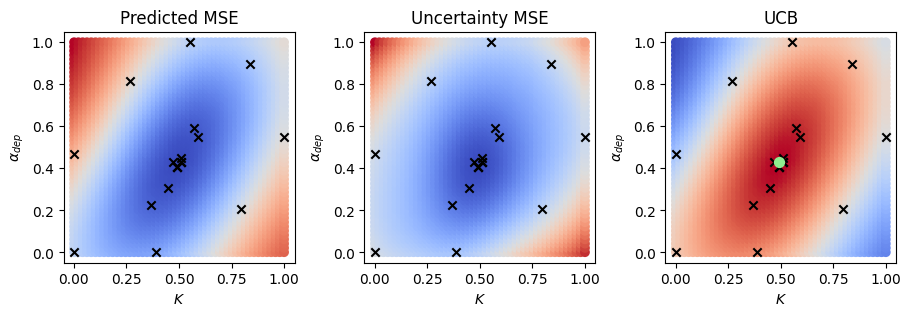

In [18]:
n_steps = 601

#experiment/theory ratio
exp_th = 1

#number of seed points theory
N = 5 #min 2

#number of seed points exp
N_exp = 10

#theory update rate
upd_rate = 20

#outer gp params
ls = dist.Gamma(2, 5)

#beta for UCB of outer loop
beta0 = 100
beta_last = 0.001

# Calculate the decay rate
beta_sequence = sigmoid_decay(beta0, beta_last, n_steps, a=2.5, b=0)

#'tail' to train DKL-T model
mem_tail = 20

lambda_y = lambda x, coupl, a_dep: ferrosim_calc(x,
                                                gamma = 100,
                                                defect_field = (30,0),
                                                c_const = coupl,
                                                Eamp = (1E-9, 2),
                                                time_vec_length = 5000,
                                                dep_alpha = a_dep)

list_model_seed = np.random.randint(0,len(coord_adj), 10) #in cycle it mistically choose the same element every time

seeds_model = [list_model_seed[0],]
c, a = coord_adj[seeds_model[-1]]

mse = []

res_dict = {'X_th': X,
            'coord_th': coords_th,
            'X_exp': X_exp,
            'coords_exp': coords,
            'coord_adj': coord_adj}




print('\n----------------- Seed points theory -----------------\n')
seeds, X_train_dkl, y_train_dkl, y_train, loops_arrays = seeds_theory(np.array(X), n=N, adj_p = (c,a))
#vis_seeds(seeds, X, loops_arrays, par=(c,a))

res_dict['y_seed_th'] = y_train
res_dict['seed_th'] = seeds

print('\n----------------- Seed points exp. -----------------\n')
seed_exp, X_train_exp, y_train_exp = seeds_exp(X_exp, loop_exp, volt_exp, coords_exp, n=N_exp)
#vis_seeds_exp(seed_exp, b_features_all, loop_exp, volt_exp, coords_exp)

res_dict['y_seed_exp'] = y_train_exp
res_dict['seed_exp'] = seed_exp


for i in range(n_steps):
  res_dict['iter_{}'.format(i)] = {}

  print(f'\n----------------- Iteration exp. {i} -----------------\n')
  seed_exp, X_train_exp, y_train_exp, dkl_res_exp, dkl_model_exp = iteration_exp(seed_exp,
                                                                                 X_exp,
                                                                                 loop_exp,
                                                                                 volt_exp,
                                                                                 coords_exp)
  res_dict['iter_{}'.format(i)]['seed_exp'] = seed_exp
  res_dict['iter_{}'.format(i)]['y_exp'] = y_train_exp
  res_dict['iter_{}'.format(i)]['dkl_res_exp'] = dkl_res_exp
  res_dict['iter_{}'.format(i)]['params_exp'] = dkl_model_exp.get_samples()[1]


  if i % exp_th == 0:
    print(f'\n----------------- Iteration theory {i} -----------------\n')
    seeds, X_train_dkl, y_train, dkl_res, dkl_model_th = iteration_theory(seeds,
                                                                          np.array(X),
                                                                          X_train_dkl,
                                                                          y_train,
                                                                          coords=coords_th,
                                                                          adj_p = (c,a),
                                                                          mem_tail = mem_tail)
    res_dict['iter_{}'.format(i)]['seed_th'] = seeds
    res_dict['iter_{}'.format(i)]['y_th'] = y_train
    res_dict['iter_{}'.format(i)]['dkl_res_th'] = dkl_res
    res_dict['iter_{}'.format(i)]['params_th'] = dkl_model_th.get_samples()[1]

    if (i > 0) and (i % (exp_th*upd_rate)==0):
      print(f'\n----------------- Theory model tune iter_{i} -----------------\n')
      key1, key2 = gpax.utils.get_keys()
      patterns_exp = b_features_all[seed_exp]#[-tail_mse:]]
      sh = patterns_exp.shape
      y_th, _ = dkl_model_th.predict(key1, patterns_exp.reshape(sh[0], -1))

      _, n_y_tr = normalize(y_train_exp)#[-tail_mse:])
      _, n_y_th = normalize(y_th)

      mse.append(np.mean(np.square(n_y_tr - n_y_th))*10)
      print(f'MSE {round(mse[-1], 2)}')

      res_dict['iter_{}'.format(i)]['mse'] = mse

      if len(mse) < 3: #initially choose randomly
        seeds_model.append(list_model_seed[len(mse)])
        res_dict['iter_{}'.format(i)]['seeds_model'] = seeds_model

        c, a = coord_adj[seeds_model[-1]]
      else:
        print('UCB beta = ', round(beta_sequence[i],3))
        next_seeds_model, pred, params = model_adjust_iteration(seeds_model,
                                                                np.array(mse),
                                                                np.array(coord_adj),
                                                                mem_tail = 50,
                                                                beta = beta_sequence[i],
                                                                lengthscale_prior_dist=ls)


        seeds_model.append(next_seeds_model)
        c, a = coord_adj[seeds_model[-1]]

        res_dict['iter_{}'.format(i)]['pred_adj'] = pred
        res_dict['iter_{}'.format(i)]['params_adj'] = params
        res_dict['iter_{}'.format(i)]['seeds_model'] = seeds_model

In [ ]:
save_dict_to_hdf5('res_exp.h5', res_dict)

# 6. Forensic

Pre-aquired data

In [19]:
!gdown https://drive.google.com/file/d/1Is2r-o91SXtJq2vIRmSbeCmJLb-bTr7O/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1Is2r-o91SXtJq2vIRmSbeCmJLb-bTr7O
To: /content/3_exp_th_standard
100% 39.3M/39.3M [00:00<00:00, 115MB/s]


In [20]:
#@title forensic functions
def trajectory_forensic(file_name):

  def get_numeric_suffix(item):
    return int(item.split('_')[-1])

  traj_data = load_hdf5_to_dict(file_name)
  iter_elements = [element for element in traj_data.keys() if element.startswith('iter_')]
  iter_elements = sorted(iter_elements, key=get_numeric_suffix)

  res_dict = {'X_exp':       traj_data['X_exp'],
              'coord_exp':  traj_data['coords_exp'],
              'seed_exp':    traj_data['seed_exp'],
              'y_seed_exp':  traj_data['y_seed_exp'],

              'X_th':        traj_data['X_th'],
              'coord_th':    traj_data['coord_th'],
              'seed_th':     traj_data['seed_th'],
              'y_seed_th':   traj_data['y_seed_th'],

              'coord_out': traj_data['coord_adj']}

  dkl_res_exp = []
  dkl_res_th  = []
  dkl_res_out = []

  ind_exp     = np.array([], dtype=int)
  ind_th      = np.array([], dtype=int)
  ind_mse     = np.array([], dtype=int)
  ind_dkl_out = np.array([], dtype=int)

  dkl_out_klength = []
  dkl_out_kscale  = []
  dkl_out_noise   = []


  for el in iter_elements:
    i = int(el.split('_')[1])
    ind_exp = np.append(ind_exp, i)

    dkl_res_exp.append(traj_data[el]['dkl_res_exp'])
    if 'dkl_res_th' in traj_data[el]:
      ind_th = np.append(ind_th, i)
      dkl_res_th.append(traj_data[el]['dkl_res_th'])

    if 'mse' in traj_data[el]:
      ind_mse = np.append(ind_mse, i)

    if 'params_adj' in traj_data[el]:
      ind_dkl_out = np.append(ind_dkl_out, i)
      dkl_res_out.append(traj_data[el]['pred_adj'])
      dkl_out_klength.append(traj_data[el]['params_adj']['k_length'])
      dkl_out_kscale.append(traj_data[el]['params_adj']['k_scale'])
      dkl_out_noise.append(traj_data[el]['params_adj']['noise'])

  res_dict['ind_exp']              = ind_exp
  res_dict['dkl_res_exp']          = np.array(dkl_res_exp)
  res_dict['seed_last_step_exp']   = np.array(traj_data[iter_elements[-1]]['seed_exp'])
  res_dict['y_exp']                = np.array(traj_data[iter_elements[-1]]['y_exp'])

  res_dict['ind_th']               = ind_th
  res_dict['dkl_res_th']           = np.array(dkl_res_th)
  res_dict['seed_last_step_th']    = np.array(traj_data[f'iter_{ind_th[-1]}']['seed_th'])
  res_dict['y_th']                 = np.array(traj_data[f'iter_{ind_th[-1]}']['y_th'])

  res_dict['ind_mse']              = ind_mse
  res_dict['mse']                  = np.array(traj_data[f'iter_{ind_mse[-1]}']['mse'])

  res_dict['ind_dkl_out']          = ind_dkl_out
  res_dict['dkl_res_out']          = np.array(dkl_res_out)
  res_dict['seed_last_step_out']   = np.array(traj_data[f'iter_{ind_dkl_out[-1]}']['seeds_model'])
  res_dict['dkl_out_klength']      = np.array(dkl_out_klength)
  res_dict['dkl_out_noise']        = np.array(dkl_out_noise)
  res_dict['dkl_out_kscale']       = np.array(dkl_out_kscale)

  return res_dict


In [21]:
#@title beta

'''
Unfortunately, I did not save the beta sequence in the data files.
This the beta decay I used for the experimentation presented in the article.
'''

# Calculate the decay rate
beta_sequence = sigmoid_decay(100, 0.001, 600, a=2.5, b=0)

In [22]:
res = trajectory_forensic('/content/3_exp_th_standard')

In [23]:
#extract some specific dependencies from the dict
dkl_exp = res['dkl_res_exp'].mean(-1)
dkl_th = res['dkl_res_th'].mean(-1)

Text(0, 0.5, 'Average uncertainty')

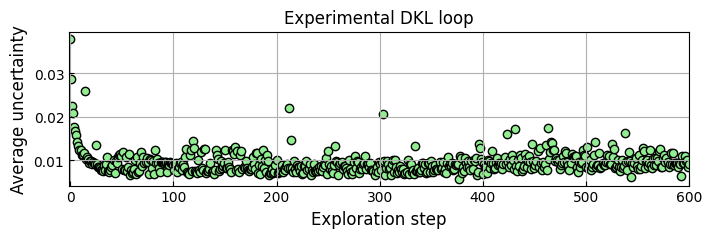

In [24]:
fig, ax = plt.subplots(figsize=(8,2))

ax.scatter(res['ind_exp'], dkl_exp[:,1], marker='o', c='lightgreen',
              edgecolor='black')

ax.set_title('Experimental DKL loop')
ax.set_xlim(-1,600)
ax.tick_params('both', direction='in')
ax.grid(True)
ax.set_xlabel('Exploration step', fontsize=12)
ax.set_ylabel('Average uncertainty', fontsize=12)

Text(0, 0.5, 'Average uncertainty')

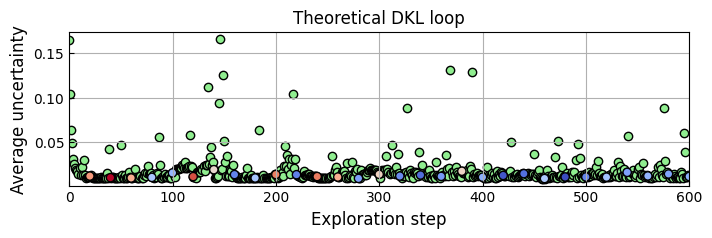

In [25]:
fig, ax = plt.subplots(figsize=(8,2))

ax.scatter(res['ind_th'], dkl_th[:,1], marker='o', c='lightgreen',
              edgecolor='black')
ax.scatter(res['ind_mse'], dkl_th[res['ind_mse'],1], marker='o', c=res['mse'],
              cmap='coolwarm', edgecolor='black')

ax.set_title('Theoretical DKL loop')
ax.set_xlim(0,600)
ax.tick_params('both', direction='in')
ax.grid(True)
ax.set_xlabel('Exploration step', fontsize=12)
ax.set_ylabel('Average uncertainty', fontsize=12)

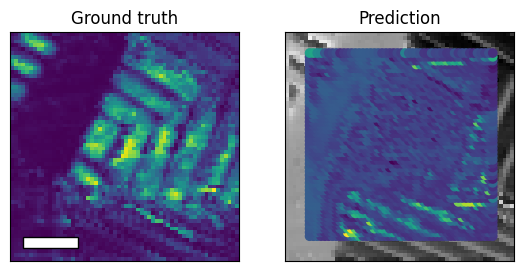

In [26]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3))

origin = 0.05*patch_image.shape[0], 0.05*patch_image.shape[1]
length = len(patch_image[0])/4.2
height = length/5

ax[0].imshow(areas, origin='lower')
ax[0].set_title('Ground truth')
ax[0].add_patch(patches.Rectangle(origin, length, height, color = 'white', ec='k', lw=1, fill = True))

ax[1].imshow(patch_image, cmap='gray', origin='lower')
ax[1].scatter(res['coord_exp'][:,1], res['coord_exp'][:,0],  c=res['dkl_res_exp'][-100,0])
ax[1].set_title('Prediction')


for _ in ax:
  _.set_xticks([])
  _.set_yticks([])

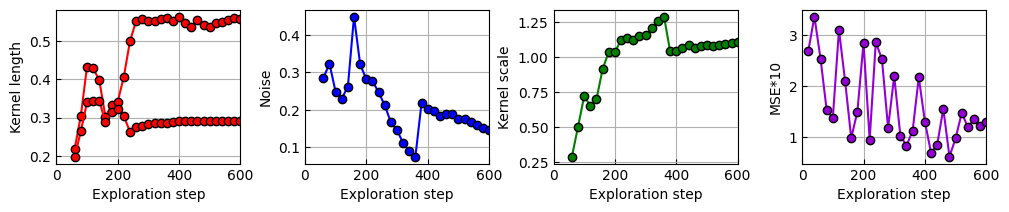

In [27]:
fig, ax = plt.subplots(1,4, figsize=(12,2))
fig.subplots_adjust(wspace=0.35)

# for dat in np.array(kl_adj).T:
ax[0].plot(res['ind_dkl_out'],
           res['dkl_out_klength'],
           'o-', c='r', mec='black')
ax[0].set_ylabel('Kernel length')

ax[1].plot(res['ind_dkl_out'],
           res['dkl_out_noise'],
           'o-', c='b', mec='black')
ax[1].set_ylabel('Noise')

ax[2].plot(res['ind_dkl_out'],
           res['dkl_out_kscale'],
           'o-', c='g', mec='black')
ax[2].set_ylabel('Kernel scale')

ax[3].plot(res['ind_mse'],
           res['mse'],
           'o-', c='darkviolet', mec='black')
ax[3].set_ylabel('MSE*10')

for _ in ax:
  _.set_xlim(0,600)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')


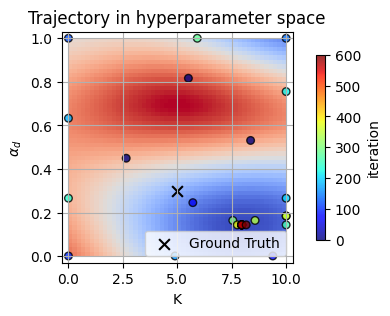

In [28]:
coord_out = res['coord_out']
seeds_out = res['seed_last_step_out']

cc = np.zeros(len(seeds_out))
cc[-len(res['ind_dkl_out']):] = res['ind_dkl_out']

fig,ax = plt.subplots(figsize=(6,3))
ax.imshow(res['dkl_res_out'][-1][0].reshape(50,50).T, extent=(0,10,0,1), origin='lower', cmap='coolwarm')
ax.set_aspect(10)

im= ax.scatter(coord_out[seeds_out][:,0]*10,
               coord_out[seeds_out][:,1],
               c=cc, s=30, alpha=0.8,
               cmap='jet', edgecolor='black',
               )

ax.scatter(0.5*10,
           0.3,
           marker= 'x',
           s=60,
           c= 'black',
           label = 'Ground Truth')

fig.colorbar(im, label='iteration', shrink=0.8)

ax.set_title('Trajectory in hyperparameter space')
ax.set_xlabel('K')
ax.set_ylabel(r"$\alpha_{d}$")
ax.set_xlim(-0.3,10.3)
ax.set_ylim(-0.03,1.03)
ax.grid()
ax.legend(loc='lower right')

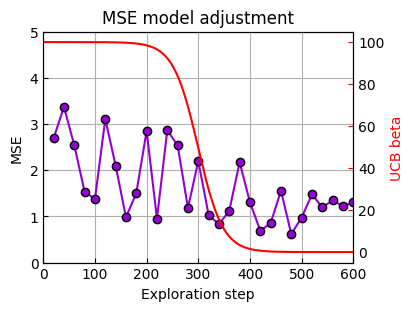

In [29]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(res['ind_mse'], res['mse'], 'o-', c='darkviolet', mec='black')
ax.set_title('MSE model adjustment')
ax1 = ax.twinx()

ax1.plot(beta_sequence, c='r')
ax1.set_ylabel('UCB beta', c='r')
ax1.tick_params('both', color='r', direction='in')

for _ in [ax,]:
  _.set_xlim(0,600)
  _.set_ylim(0,5)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')
  _.set_ylabel('MSE')

In [30]:
dif_coord = coord_out[seeds_out][1:] - coord_out[seeds_out][:-1]
dist_coord = abs(dif_coord[:,0] - dif_coord[:,1])

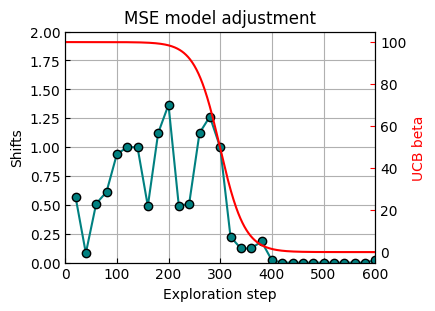

In [31]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(res['ind_mse'], dist_coord, 'o-', c='teal', mec='black')
ax.set_title('MSE model adjustment')

ax1 = ax.twinx()
ax1.plot(beta_sequence, c='r')
ax1.set_ylabel('UCB beta', c='r')
ax1.tick_params('both', color='r', direction='in')

for _ in [ax,]:
  _.set_xlim(0,600)
  _.set_ylim(0,2)
  _.tick_params('both', direction='in')
  _.grid(True)
  _.set_xlabel('Exploration step')
  _.set_ylabel('Shifts')

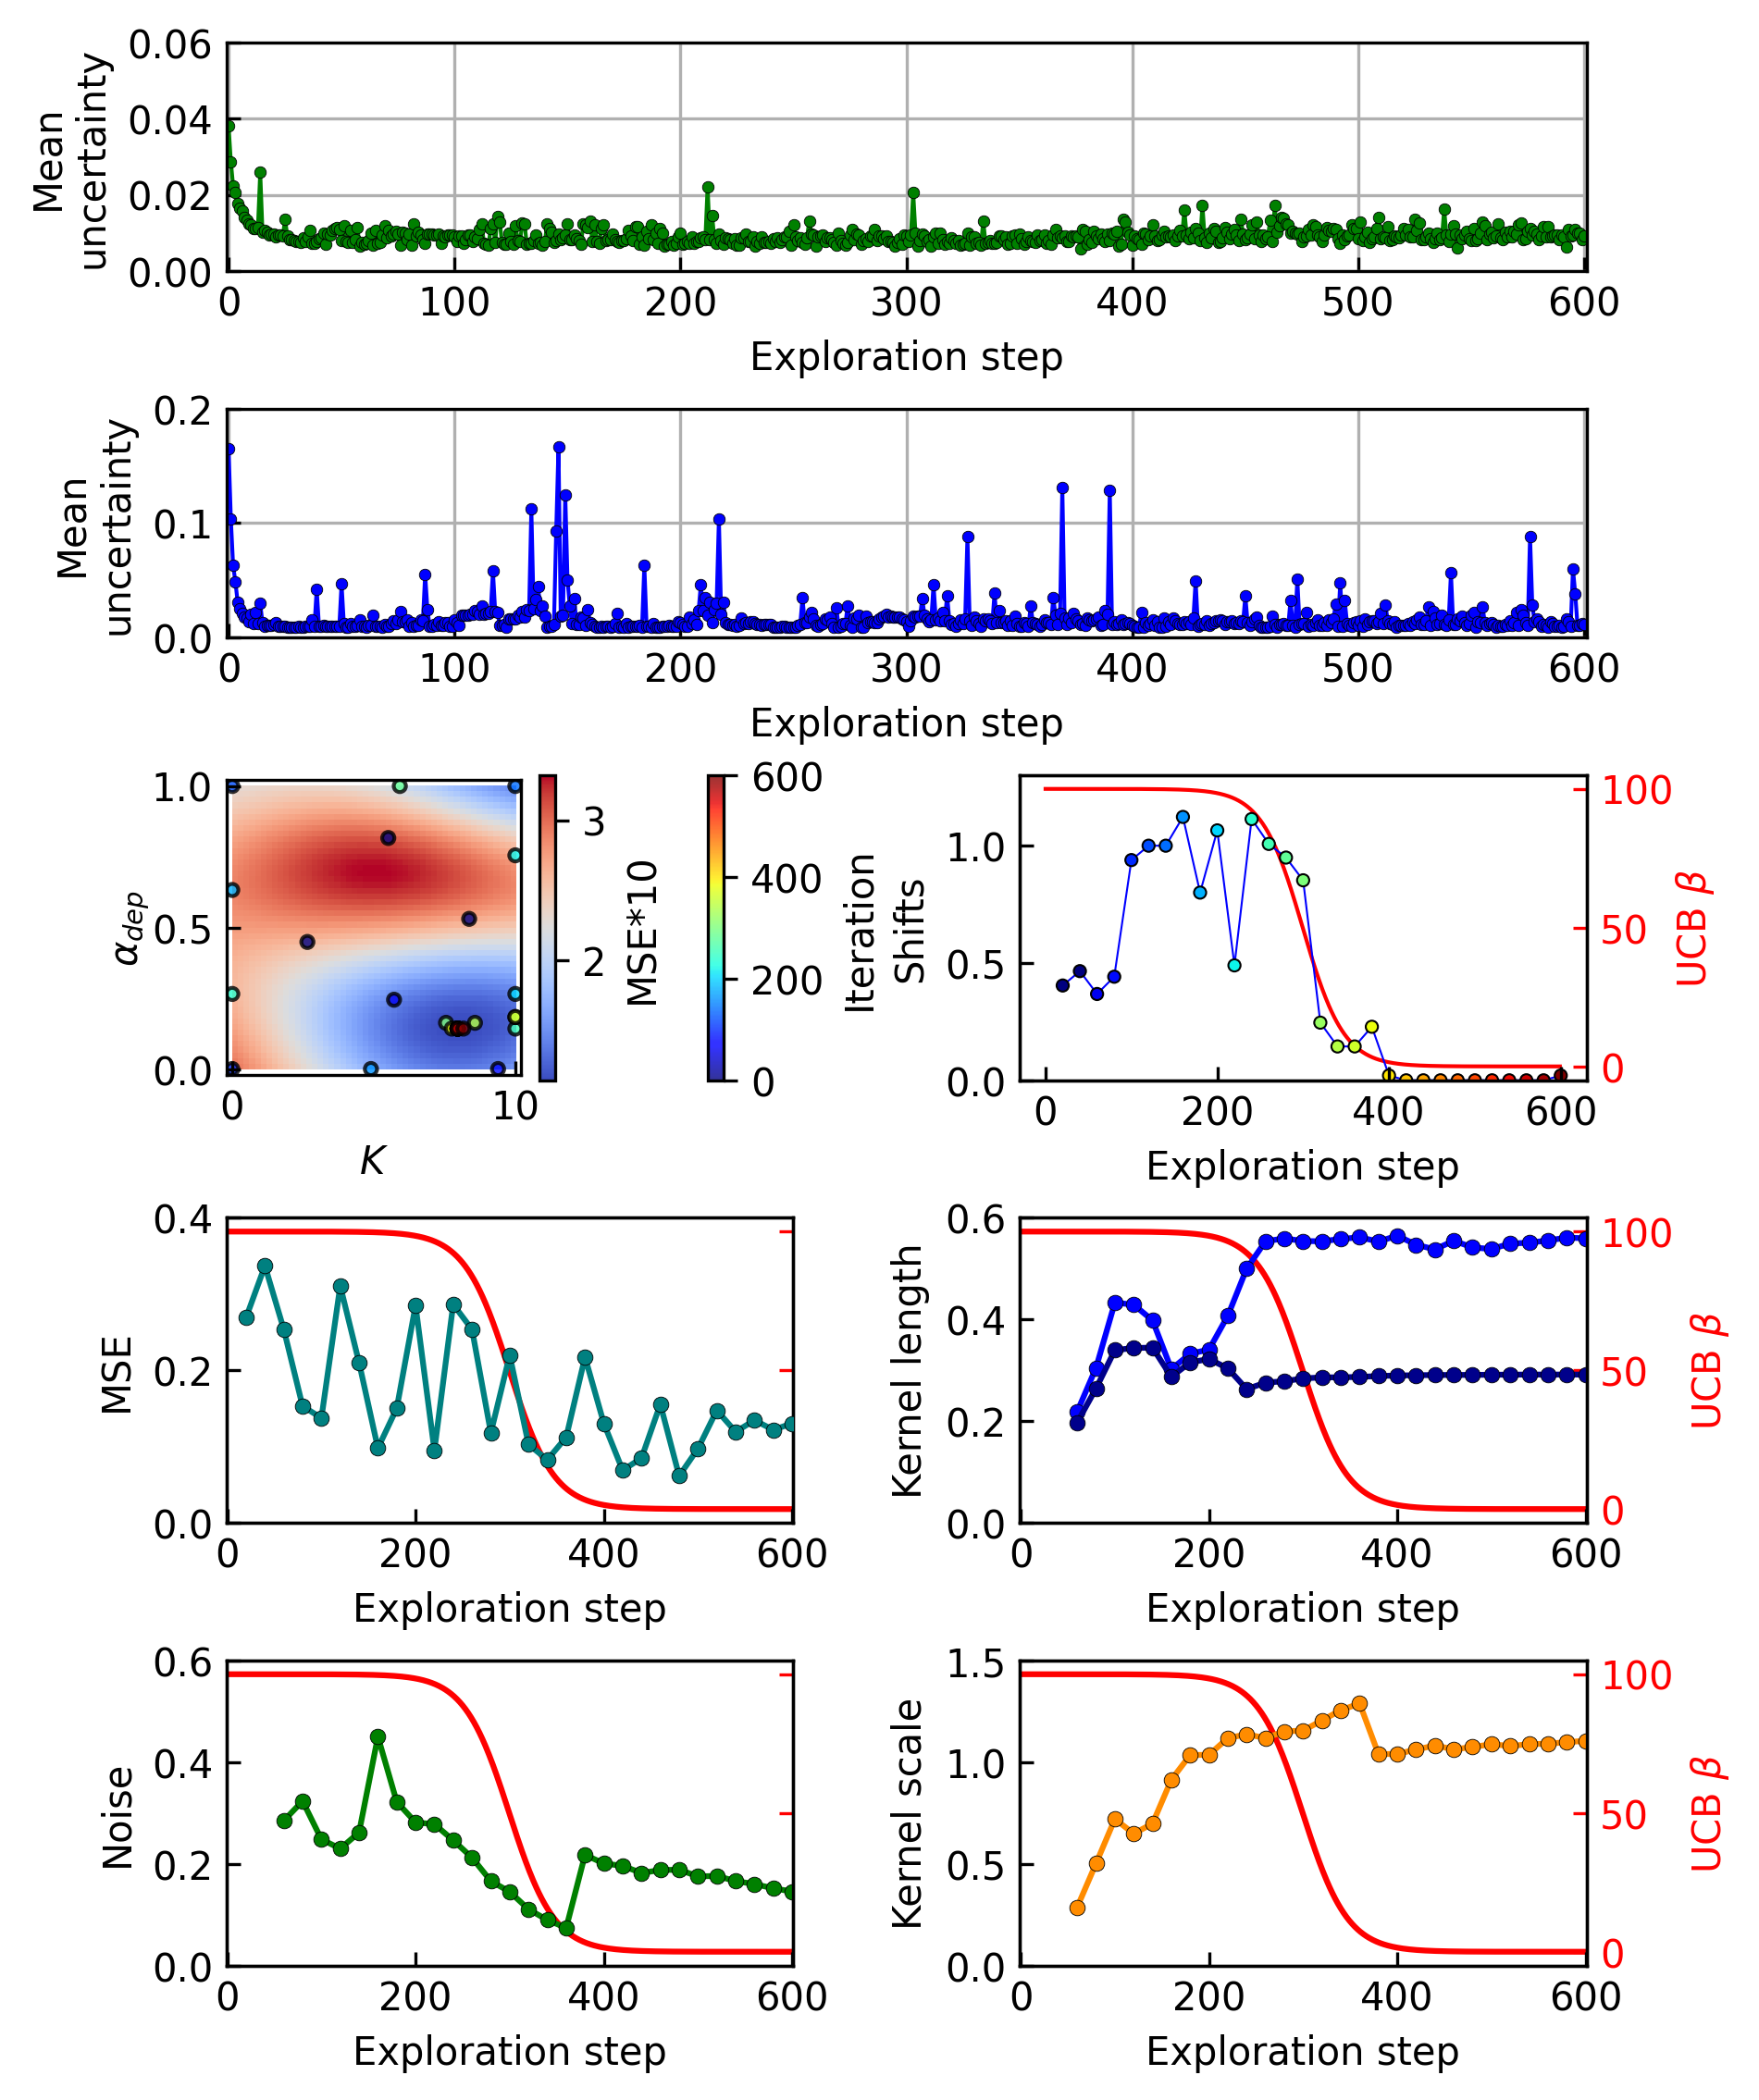

In [32]:
#@title for article: experiment results
coords_norm   = res['coord_out'][res['seed_last_step_out']]
dif_coord_norm  = coords_norm[1:] - coords_norm[:-1]
dist_coord_norm = (dif_coord_norm[:,0]**2 + dif_coord_norm[:,1]**2)**0.5

cc = np.zeros(len(coords_norm))
cc[-len(res['ind_dkl_out']):] = res['ind_dkl_out']

dkl = res['dkl_res_out'][-1][0]

fig = plt.figure(figsize=(7, 9), dpi = 300)
fig.subplots_adjust(wspace=0.4, hspace=0.5, left=0.2)
gs = gridspec.GridSpec(5, 2, height_ratios=(1.5,1.5,2,2,2))

#_________________ ax0, ax1 ___________________________
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])

ax0.plot(res['ind_exp'], dkl_exp[:,1], 'o-', c='green',
              mec='black', mew=0.2, ms=3, lw=1)
ax0.set_ylim(0, 0.06)
ax0.set_yticks([0,0.02,0.04,0.06])

ax0.set_xlim(-1,200)
ax0.tick_params('both', direction='in')
ax0.set_xlabel('Exploration step', fontsize=10)
ax0.set_ylabel('Mean uncertainty', fontsize=10)


ax1.plot(res['ind_th'], dkl_th[:,1], 'o-', c='blue',
            mec='black', mew=0.2, ms=3, lw=1)
ax1.set_ylim(0, 0.2)
ax1.set_xlabel('Exploration step', fontsize=10)

for _ in [ax0, ax1]:
  _.grid(True)
  _.set_xlim(-1, 601)

  _.set_ylabel('Mean\nuncertainty', fontsize=10)
  _.tick_params('both', direction='in')

# ______________________ax3, ax4___________________
ax3 = fig.add_subplot(gs[2,0])

im0 = ax3.imshow(dkl.reshape(int(len(dkl)**0.5),
                                int(len(dkl)**0.5)).T,
                 extent=(0,10,0,1),
                 origin='lower',
                 cmap='coolwarm')
ax3.set_aspect(10)

im_sc= ax3.scatter(coords_norm[:,0]*10,
                   coords_norm[:,1],
                   c=cc, s=10, alpha=0.8,
                   cmap='jet', edgecolor='black',)
ax3.set_xlim(-0.2, 10.2)
ax3.set_ylim(-0.02, 1.02)

cbar_sc = fig.colorbar(im_sc, ax=ax3, pad=0.2)
cbar_sc.set_label('Iteration')
cbar = fig.colorbar(im0, ax=ax3, pad=0.05)
cbar.set_label('MSE*10')

ax3.set_xlabel(r'$K$')
ax3.set_ylabel(r'$\alpha_{dep}$', labelpad=0.01, )
ax3.tick_params('both', direction='in')

ax4 = fig.add_subplot(gs[2,1])

ax4.plot(res['ind_mse'],
             dist_coord_norm,
             zorder=0,
             lw=0.5,
             c='b')
ax4.scatter(res['ind_mse'],
            dist_coord_norm,
            marker='o',
            c=cc[1:],
            cmap='jet',
            s=10,
            ec='black',
            lw=0.5,
            zorder=1)


ax4.set_ylabel('Shifts')
ax4.set_xlabel('Exploration step')
ax4.set_ylim(0,1.3)
ax4.set_zorder(1)
ax4.set_facecolor('none')
ax4.tick_params('both', direction='in')
axx = ax4.twinx()
axx.plot(beta_sequence, c='r', lw=1)
axx.tick_params('both', color='r', direction='in')
axx.set_ylabel(r'UCB $\beta$', c='r', labelpad=0)
axx.set_yticks([0,50,100])
axx.set_yticklabels([0,50,100], c='r')
axx.set_zorder(_.get_zorder() - 1)

#__________________ax5 - ax8___________________

ax5 = fig.add_subplot(gs[3,0])
ax6 = fig.add_subplot(gs[3,1])
ax7 = fig.add_subplot(gs[4,0])
ax8 = fig.add_subplot(gs[4,1])

#MSE
ax5.plot(res['ind_mse'],
         res['mse']/10,
         'o-', c='teal', mec='black',
         ms=4, mew=0.2, zorder=5)
ax5.set_ylabel('MSE')
ax5.set_ylim(0,0.4)

#kernel length
ax6.plot(res['ind_dkl_out'],
         res['dkl_out_klength'][:,0],
         'o-', c='blue', mec='black',
         ms=4, mew=0.2)
ax6.set_ylim(0,0.6)

ax6.plot(res['ind_dkl_out'],
         res['dkl_out_klength'][:,1],
         'o-', c='darkblue', mec='black',
         ms=4, mew=0.2)
ax6.set_ylabel('Kernel length')

#noise
ax7.plot(res['ind_dkl_out'],
         res['dkl_out_noise'],
         'o-', c='green', mec='black',
         ms=4, mew=0.2)
ax7.set_ylabel('Noise')
ax7.set_ylim(0,0.6)

#Kernel scale
ax8.plot(res['ind_dkl_out'],
         res['dkl_out_kscale'],
         'o-', c='darkorange', mec='black',
         ms=4, mew=0.2)
ax8.set_ylabel('Kernel scale')
ax8.set_ylim(0,1.5)

ax_params = [ax5, ax6, ax7, ax8]

for _ in ax_params:
  _.tick_params('both', direction='in')
  _.set_xlim(-1, 601)
  _.set_zorder(1)
  _.set_facecolor('none')
  _.set_xlabel('Exploration step')

  axx = _.twinx()
  axx.plot(beta_sequence, c='r')
  axx.tick_params('both', color='r', direction='in')
  axx.set_zorder(0)

  if  _ in [ax6,ax8]:
    axx.set_ylabel(r'UCB $\beta$', c='r')
    axx.set_yticks([0,50,100])
    axx.set_yticklabels([0,50,100], c='r')
  if  _ in [ax5,ax7]:
    axx.set_yticklabels([])